In [15]:
#Carga las librerías
%matplotlib inline
%config InlineBackend.figure_format="retina"
from numpy import loadtxt, savetxt, unique, ones, exp, zeros,  array, concatenate, hstack, where, mean, std, linspace
from numpy import sum as npsum
import scipy as sp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as ms
mpl.rcParams.update({'font.size': 16, 'font.weight':'bold', 'font.style':'normal'})
import seaborn  as sns
from numpy import matlib
from lmfit import Model
import pickle as pkl
import sys
from os import name as nameos
# insert at 1, 0 is the script path (or '' in REPL)
if nameos=="posix":
    sys.path.insert(1, '/home/sparra/MEGA/Prpy')
else:
    sys.path.insert(1, 'C:\\Users\\sparra\\Documents\\Prpy')
from Phd import fitmatlab
#font = "sans-serif"#'tex gyre heros'  # an open type font
#mpl.rcParams['font.sans-serif'] = font
mpl.rcParams.update({'font.size': 16, 'font.weight':'bold', 'font.style':'normal'})
plt.rc('font', family='serif')
#mpl.rc('mathtext', fontset='custom')
mpl.rc('font', size=14)  # change font size from default 10
ms.use('default')
#mpl.rc('text', usetex=True)
#import xarray as xarr
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------      Definición de funciones    ---------------------------------------------

def sigmoidal(X,a,b,c,d):
    return (a-b)/(1+exp((d-X)/c))+b

#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#                  Carga de archivos y fijación de parámetros y máscaras
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------

# Loading data.
if nameos=="posix":
    RR032=loadtxt("/home/sparra/MEGA/Prpy/Neurometria_tasa_RR032.csv", delimiter=',')
    RR033=loadtxt("/home/sparra/MEGA/Prpy/Neurometria_tasa_RR033.csv", delimiter=',')
    filesRR032=loadtxt("/home/sparra/MEGA/Prjl/S1_Inc_RR032_Totales.csv", usecols=(0, 4), skiprows=(1), delimiter=",")
    filesRR033=loadtxt("/home/sparra/MEGA/Prjl/S1_Inc_RR033.csv", usecols=(0, 4), delimiter=",", skiprows=(1))

else:
    RR032=loadtxt("C:\\Users\\sparra\\Documents\\Prpy\\Neurometria_tasa_RR032.csv", delimiter=',')
    RR033=loadtxt("C:\\Users\\sparra\\Documents\\Prpy\\Neurometria_tasa_RR033.csv", delimiter=',')
    filesRR032=loadtxt("C:\\Users\\sparra\\Documents\\Prjl\\S1_Inc_RR032_Totales.csv", usecols=(0, 4), skiprows=(1), delimiter=",")
    filesRR033=loadtxt("C:\\Users\\sparra\\Documents\\Prjl\\S1_Inc_RR033.csv", usecols=(0, 4), delimiter=",", skiprows=(1))

indexes={"serie":0, "electrodo":1, "unidad":2, "3b":3, "CR":4, "setN":5, "setId":6}
# máscaras
mask33CR1=RR033[:, indexes["CR"]]==1
mask33CR2=RR033[:, indexes["CR"]]==2
mask33CR3=RR033[:, indexes["CR"]]>=3
mask333b=RR033[:, indexes["3b"]]==1

mask32CR1=RR032[:, indexes["CR"]]==1
mask32CR2=RR032[:, indexes["CR"]]==2
mask32CR3=RR032[:, indexes["CR"]]>=3
mask323b=RR032[:, indexes["3b"]]==1
# amplitudes 
filesRR032b=unique(filesRR032, axis=0)
filesRR033b=unique(filesRR033, axis=0)

DicsetT={"1":[0,4,14,16,20, 24],"6":[0, 4, 8, 10, 14, 24], "11":[0, 4 ,8, 12, 14, 24], "13":[0,4,10,16,20,24]}

ampT=[0, 4, 6, 8, 10, 12, 14, 16, 20, 24]
ampA=[0]; 
ampA  += list (map(fitmatlab, [0.006, 0.1, 0.5, 1, 2.5])                )
print(ampA)
r32, c32 = RR032.shape
r33, c33 = RR033.shape

#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#                  Cálculo de neurometría fusionada
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------

# Creación del vector x, y para la realización del ajuste neurométrico acústico.
neu_acus=zeros( ((r32 +r33)* 6, 4), dtype=float)
cols=[13, 14, 15, 16, 17, 18 ]
pos=0   #Indice del renglón donde se escribirá
x=ones((r32 + r33), dtype=float)
for i in range(len(cols)):
    neu_acus[pos: pos +r32 +r33 , 0 ]=x*ampA[i]
    neu_acus[pos:pos +r32 , 1:: ]=RR032[:, [indexes["3b"], indexes["CR"], cols[i] ] ]
    neu_acus[pos  +r32: pos +r32 +r33 , 1:: ]=RR033[:, [indexes["3b"], indexes["CR"], cols[i] ] ]
    pos +=r32 +r33


# Creación del vector x, y para la realización del ajuste neurométrico táctil.
neu_tac=zeros( ((r32 +r33)* 6, 4), dtype=float)
cols=[7, 8, 9, 10, 11, 12 ]
pos=0   #Indice del renglón donde se escribirá
x=ones((r32), dtype=float)
at32=[0, 6, 8, 10, 12, 24]
for i in range(len(cols)):
    neu_tac[pos: pos +r32, 0 ]=x*at32[i]
    neu_tac[pos:pos +r32 , 1:: ]=RR032[:, [indexes["3b"], indexes["CR"], cols[i] ] ]
    pos +=r32

for i in range(r33):
    neu_tac[pos: pos +6, 1:3 ]=RR033[i, [indexes["3b"], indexes["CR"] ] ]
    #x=DicsetT[str( RR033[i, indexes["setId"] ] )]
    neu_tac[pos:pos +6, 0]=DicsetT[str( int(RR033[i, indexes["setId"] ] ))]  #Amplitudes
    neu_tac[pos:pos +6, 3]=list(RR033[i, cols])
    pos +=6


#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#                  Cálculo de psicometria fusionada (Resultados obtenidos con la libreta Psicofisica_S1)

#Resultados Táctiles: 

#Psicofísica:   
#Amplitudes:  [0, 4, 6, 8, 10, 12, 14, 16, 20, 24] 
# Probabilidad:  [0.13187304 0.06547619 0.05376344 0.1498829  0.3375     0.56532663 
#                 0.74683544 0.75       0.75       0.85011186] 

#Parámetros del ajuste: 0.791319 	 0.078899 	 1.315086 	 10.867245

 # ---------------------------------------------------------------
# Resultados Acústicos: 
# Amplitudes:  [0, 30.40014333689977, 35.54467624793413, 45.4695870486123, 51.24204871464509, 59.598553937113024] 
#  Probabilidad:  [0.13187304 0.11383929 0.60491071 0.83892617 0.89508929 0.93526786] 

#Parámetros del ajuste: 0.891063 	 0.000000 	 1.952362 	 34.102654
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------
Amplitudes=((0, 4, 6, 8, 10, 12, 14, 16, 20, 24), 
           (0, 30.40014333689977, 35.54467624793413, 45.4695870486123, 51.24204871464509, 59.598553937113024))
Probabilidad= ((0.03478068, 0.07549019, 0.07207793, 0.15486111, 0.3787323,  0.6236949, 0.76813, 0.75, 0.85555553, 0.880889),
               (0.10158765, 0.11113491, 0.60050005, 0.84984124, 0.8971112,  0.94905555))
paramspsic=((  0.859070, 0.032516, 1.809071, 10.807832),
            (0.919461, 0.000000 , 2.027812, 34.349509))
print("Hecho")

[0, 30.40014333689977, 35.54467624793413, 45.4695870486123, 51.24204871464509, 59.598553937113024]
Hecho


# Pruebas de neurometría e información de periodicidad

In [18]:
# Bloque de código
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from numba import njit
import Extensiones as Pext
from scipy.signal.windows import tukey
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time

In [27]:
np.unique(Caracteristicas[:, -1])

array([0., 1.])

## Prueba con un archivo relativamente bueno: 
1. RR032155_002_4_3
2. RR032156_002_7_1
3. RR032159_002_5_2
4. RR032161_002_5_2
5. RR032164_002_5_1

In [17]:
fs=100      # Frecuencia de muestreo
if nameos=="posix":
    R32=np.loadtxt("/home/sparra/MEGA/Prjl/S1_Inc_RR032.csv",
                   delimiter=",", usecols=(0,2,3,4,6,9), skiprows=1)
    R33=np.loadtxt("/home/sparra/MEGA/Prjl/S1_Inc_RR033.csv", 
                   delimiter=",", usecols=(0,2,3,4,6,9), skiprows=1)
else:
    R32=np.loadtxt("C:\\Users\\sparra\\Documents\\Prjl\\S1_Inc_RR032.csv",
                   delimiter=",", usecols=(0,2,3,4,6,9), skiprows=1)
    R33=np.loadtxt("C:\\Users\\sparra\\Documents\\Prjl\\S1_Inc_RR033.csv", 
                   delimiter=",", usecols=(0,2,3,4,6,9), skiprows=1)
R=np.concatenate((R32, R33), axis=0)
del R32, R33

NeuPerT=np.zeros((len(R), 6), dtype=np.float64)
NeuPerA=np.zeros((len(R), 6), dtype=np.float64)
AmpT_Neu=np.zeros((len(R), 6), dtype=np.float64)
AmpA_Neu=np.zeros((len(R), 6), dtype=np.float64)
Caracteristicas=np.zeros((len(R), 3), dtype=np.float64)
row=0
for arc in range(len(R)):
    #mono, serie, orden, elec, uni= (32, 164, 2, 5, 1)
    serie,  elec, uni, orden= R[arc, (0, 1, 2, 3)]
    if serie>100:
        mono=32
    else:
        mono=33
    try:
        times, psyc, spikesshort=loaddata(serie, elec, uni, orden)
    except Exception as err:
        continue
    ntrials=len(spikesshort)
    Periodicidad1=np.zeros((ntrials), dtype=np.float64)
    Periodicidad2=np.zeros((ntrials), dtype=np.float64)
    for trial_i in range(ntrials):
        tmp=spikesshort[trial_i]+1.5
        try:
            tasa=Pext.FRcausalR(tmp, 0.025, fs, -1.5, 2.0)
        except:
            #print("La longitud de las espigas es: ", len(tmp),"\t", tmp)
            tasa=np.arange(-1.5, 2, 1/100)*0
        t=np.arange(-1.5, 2, 1/100)
        # Cálculo de la periodicidad
        #plt.plot(t, tasa)
        posiciones=np.where((t>-0.2)*(t<0.7) )[0]
        segment=  tasa[posiciones]*tukey(len(posiciones))
        segment=  segment- np.mean(segment)
        segmentX=np.abs(2*fft.rfft(segment))/len(posiciones)
        freq=np.linspace(0, 50, len(posiciones))
        #plt.figure()
        #plt.plot(freq, segmentX)
        pos, pos2=np.argmin(np.abs(freq-18)), np.argmin(np.abs(freq-22))
        tmp=np.sum(segmentX)
        if tmp!=0:
            Periodicidad1[trial_i]=np.sum(segmentX[pos : pos2 + 1])/np.sum(segmentX)
        else:
            Periodicidad1[trial_i]=0
        Periodicidad2[trial_i]=np.sum(segmentX[pos : pos2 + 1])

    # Cálculo de la neurometría periodicidad
    maskA=np.where(psyc[:, 13]>0)[0]
    maskZ=np.where((psyc[:, 13]==0)*(psyc[:, 11]==0))[0]
    maskT=np.where(psyc[:, 11]>0)[0]
    nbins=20

    tmp=np.concatenate((maskZ, maskT))
    BinEdges=np.histogram_bin_edges(Periodicidad2[tmp], range=None, weights=None)
    nbins=len(BinEdges)-1
    ParamsNeuTac=neuromParams(True, BinEdges[1]-BinEdges[0], BinEdges, nbins)
    neurT,  HitsT, cT, HistogramsT=optimumC(Periodicidad2[tmp], psyc[tmp][:, 11], ParamsNeuTac, return_histogram=True)
    #
    AmpT_Neu[row, :]=np.unique(psyc[tmp][:, 11])
    #
    tmp=np.concatenate((maskZ, maskA))
    BinEdges=np.histogram_bin_edges(Periodicidad2[tmp], range=None, weights=None)
    nbins=len(BinEdges)-1
    ParamsNeuAc=neuromParams(True, BinEdges[1]-BinEdges[0], BinEdges, nbins)
    neurA,  HitsA, cA, HistogramsA=optimumC(Periodicidad2[tmp], psyc[tmp][:, 13], ParamsNeuAc, return_histogram=True)
    if np.min(neurT)==np.max(neurT):
        NeuPerT[row, :]=0
    else:
        NeuPerT[row, :]=neurT
    if np.min(neurA)==np.max(neurA):
        NeuPerA[row, :]=0
    else:
        NeuPerA[row, :]=neurA
    AmpA_Neu[row, :]=np.unique(psyc[tmp][:, 13])
    Caracteristicas[row, 1::]=R[arc, 4::]
    Caracteristicas[row, 0]=mono
    row+=1
# Ahora la reducción del vector
NeuPerT=NeuPerT[0:row, :]
NeuPerA=NeuPerA[0:row, :]
AmpA_Neu=AmpA_Neu[0:row, :]
AmpT_Neu=AmpT_Neu[0:row, :]
Caracteristicas=Caracteristicas[0:row, :]
print("Finalizado...")


Finalizado...


Ahora lo que queremos es graficar los resultados por población.

In [19]:
from scipy.optimize import curve_fit


maskCR1=Caracteristicas[:, 1]==1
maskCR2=Caracteristicas[:, 1]==2
maskCR3=Caracteristicas[:, 1]>2
# Ahora a extraer los elementos en la componente
xTCR2=AmpT_Neu[maskCR2, :].flatten()
NeuTCR2=NeuPerT[maskCR2, :].flatten()
xTCR1=AmpT_Neu[maskCR1, :].flatten()
NeuTCR1=NeuPerT[maskCR1, :].flatten()
xTCR3=AmpT_Neu[maskCR3, :].flatten()
NeuTCR3=NeuPerT[maskCR3, :].flatten()
pmod=(0.7, 0.1, 0.1, 9)
boundsmod=((0.2, -0.1, -100, 5), (1, 1, np.inf, 25))
paramsCR1, covparamsCR1=curve_fit(sigmoidal, xdata=xTCR1, ydata=NeuTCR1, p0=pmod, bounds=boundsmod)
paramsCR2, covparamsCR2=curve_fit(sigmoidal, xdata=xTCR2, ydata=NeuTCR2, p0=pmod, bounds=boundsmod)
paramsCR3, covparamsCR3=curve_fit(sigmoidal, xdata=xTCR3, ydata=NeuTCR3, p0=pmod, bounds=boundsmod)

xACR2=AmpA_Neu[maskCR2, :].flatten()
mask=xACR2>0
xACR2[mask]=fitmatlab(xACR2[mask])
NeuACR2=NeuPerA[maskCR2, :].flatten()
xACR1=AmpA_Neu[maskCR1, :].flatten()
mask=xACR1>0
xACR1[mask]=fitmatlab(xACR1[mask])
NeuACR1=NeuPerA[maskCR1, :].flatten()
xACR3=AmpA_Neu[maskCR3, :].flatten()
mask=xACR3>0
xACR3[mask]=fitmatlab(xACR3[mask])
NeuACR3=NeuPerA[maskCR3, :].flatten()

pmod=(0.7, 0.1, 0.1, 35)
boundsmod=((0.2, -0.1, -3, 34), (1, 1, 3, 70))
paramsCR1A, covparamsCR1A=curve_fit(sigmoidal, xdata=xACR1, ydata=NeuACR1, p0=pmod, bounds=boundsmod)
paramsCR2A, covparamsCR2A=curve_fit(sigmoidal, xdata=xACR2, ydata=NeuACR2, p0=pmod, bounds=boundsmod)
paramsCR3A, covparamsCR3A=curve_fit(sigmoidal, xdata=xACR3, ydata=NeuACR3, p0=pmod, bounds=boundsmod)
print(paramsCR3)
print(paramsCR3A)

[ 0.66796802  0.45321291 12.54788466 25.        ]
[ 0.3871771   0.40155584  0.17410692 39.79642255]


(-0.01, 1.01)

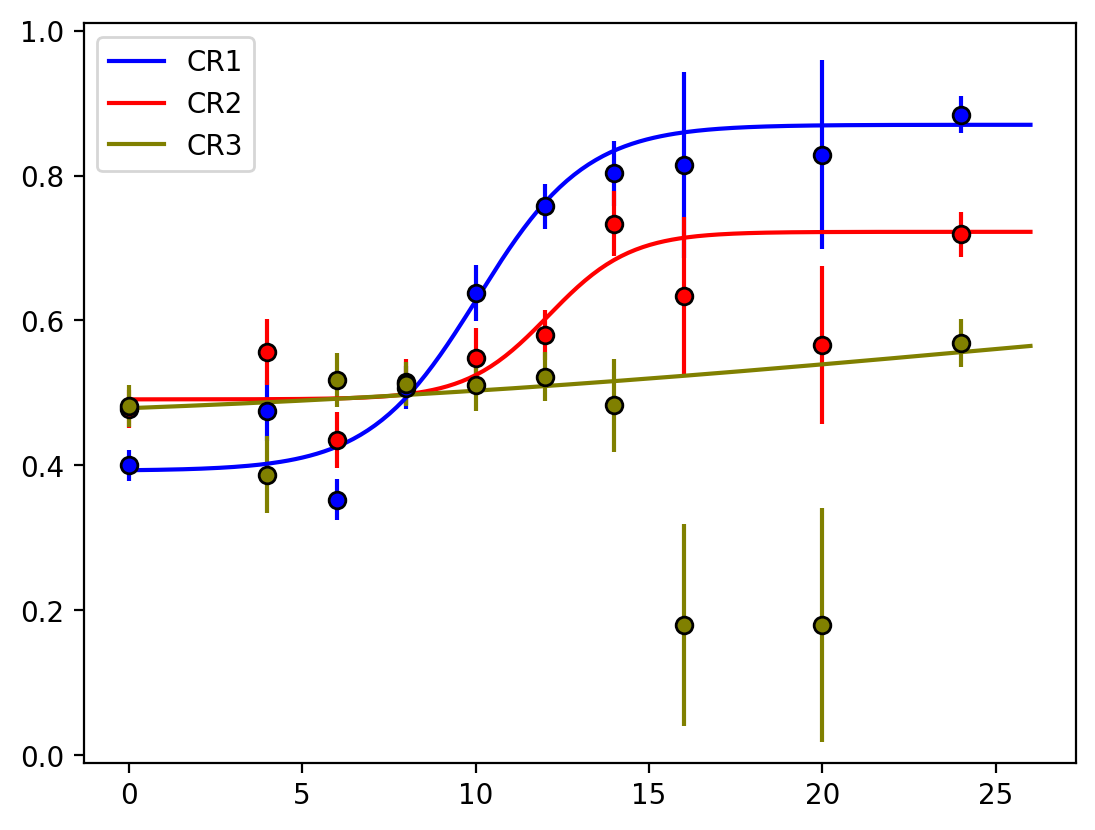

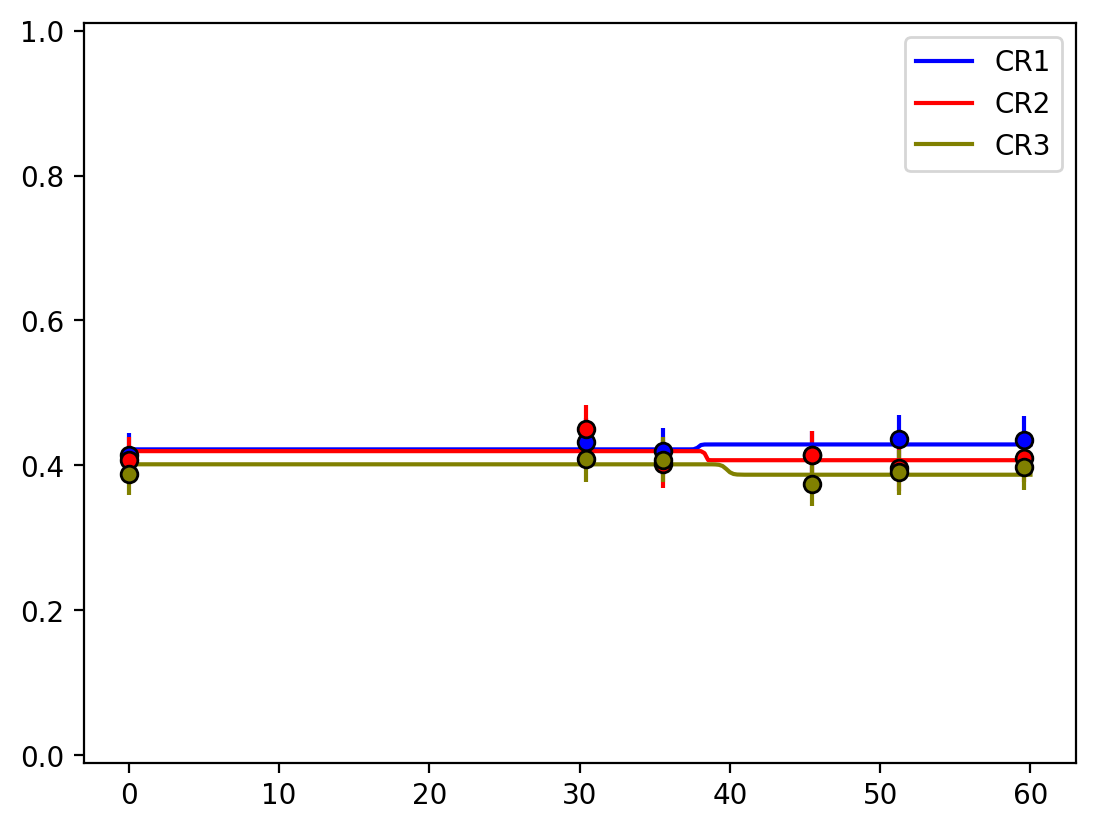

In [11]:
xsim=np.linspace(0, 26, 250)
xsimA=np.linspace(0, 60, 250)

# Extraer las medias por amplitud así como las sigmas
yACR=np.zeros((3, 6), dtype=np.float32)
yerrACR=np.zeros((3, 6), dtype=np.float32)
yTCR=np.zeros((3, 20), dtype=np.float32)
yerrTCR=np.zeros((3, 20), dtype=np.float32)

for CR in range(3):
    if CR==0:
        amps=np.unique(xTCR1)
        ampsA=np.unique(xACR1)
        
        
        
        NeuACR=NeuACR1
        NeuTCR=NeuTCR1
        xTCR=xTCR1
        xACR=xACR1
    elif CR==1:
        amps=np.unique(xTCR2)
        NeuTCR=NeuTCR2
        ampsA=np.unique(xACR2)
        NeuACR=NeuACR2
        xTCR=xTCR2
        xACR=xACR2

    else:
        amps=np.unique(xTCR3)
        NeuTCR=NeuTCR3
        ampsA=np.unique(xACR3)
        NeuACR=NeuACR3
        xTCR=xTCR3
        xACR=xACR3

    c=0
    for amp_i in amps:
        mask=xTCR==amp_i
        yTCR[CR, c]=np.mean(NeuTCR[mask])
        yerrTCR[CR, c]=np.std(NeuTCR[mask])/np.sqrt(np.sum(mask))
        c+=1
        
    c=0
    for amp_i in ampsA:
        mask=xACR==amp_i
        yACR[CR, c]=np.mean(NeuACR[mask])
        yerrACR[CR, c]=np.std(NeuACR[mask])/np.sqrt(np.sum(mask))
        c+=1
plt.errorbar(np.unique(xTCR1), yTCR[0, 0:10], yerrTCR[0, 0:10],  color="blue", mec='black', fmt='o', ecolor="blue")
plt.errorbar(np.unique(xTCR2), yTCR[1, 0:10], yerrTCR[1, 0:10],  mec='black',  color="red", fmt='o', ecolor="red")
plt.errorbar(np.unique(xTCR3), yTCR[2, 0:10], yerrTCR[2, 0:10],  mec='black',  color="olive", fmt='o', ecolor="olive")
plt.plot(xsim, sigmoidal(xsim, *paramsCR1), label="CR1", color="blue")
plt.plot(xsim, sigmoidal(xsim, *paramsCR2), label="CR2", color="red")
plt.plot(xsim, sigmoidal(xsim, *paramsCR3), label="CR3", color="olive")
plt.legend()
plt.ylim([-0.01, 1.01])

plt.figure()
plt.errorbar(np.unique(xACR1), yACR[0, 0:10], yerrACR[0, 0:10],  color="blue", mec='black', fmt='o', ecolor="blue")
plt.errorbar(np.unique(xACR2), yACR[1, 0:10], yerrACR[1, 0:10],  mec='black',  color="red", fmt='o', ecolor="red")
plt.errorbar(np.unique(xACR3), yACR[2, 0:10], yerrACR[2, 0:10],  mec='black',  color="olive", fmt='o', ecolor="olive")
plt.plot(xsimA, sigmoidal(xsimA, *paramsCR1A), label="CR1", color="blue")
plt.plot(xsimA, sigmoidal(xsimA, *paramsCR2A), label="CR2", color="red")
plt.plot(xsimA, sigmoidal(xsimA, *paramsCR3A), label="CR3", color="olive")
plt.legend()
plt.ylim([-0.01, 1.01])

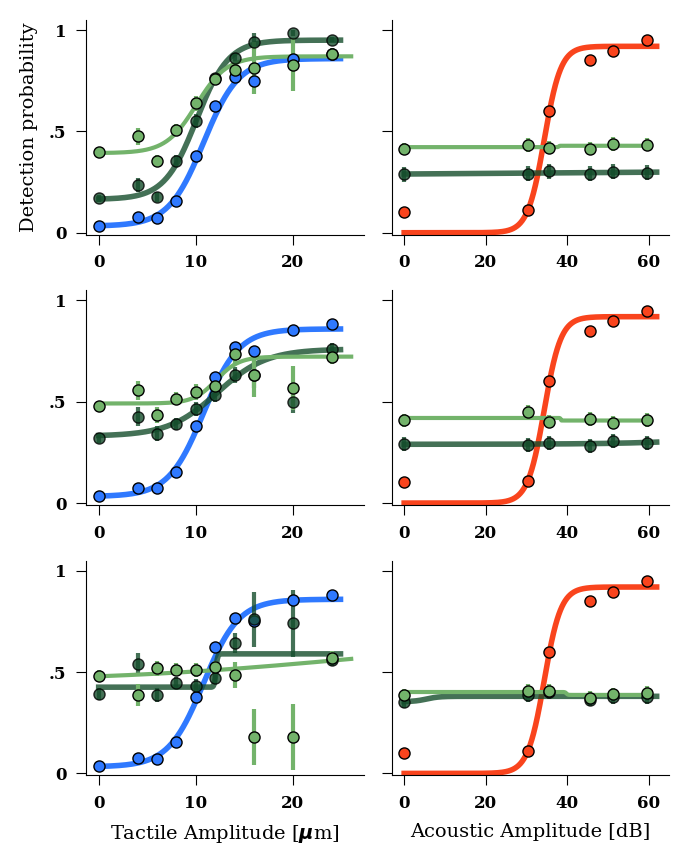

In [12]:
from numpy import arange, divide, inf
import numpy as np
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 6, 'font.weight':'bold', 'font.style':'normal'})
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'
#colors = iter([plt.cm.tab10(i) for i in range(20)])
#colors=list(colors)
colors=((21/255, 77/255, 44/255, 1), (21/255, 77/255, 44/255, 1), (21/255, 77/255, 44/255, 1), (21/255, 77/255, 44/255, 1))
colorsPsic=((47/255, 121/255, 255/255, 100/100), (249/255, 68/255, 29/255, 100/100))
def linear(X, a, b):
    return a*X + b

def sigmoidal(X, a, b, c, d):
    from numpy import exp
    return (float(a-b))/(1.0  +exp((float(d)-X.astype(float) )/float(c)) ) +float(b)

sem=( (0.00246629, 0.00934693, 0.00691324, 0.01451257, 0.02006645, 0.01941001,
 0.01409271, 0.01369306, 0.01104145, 0.00734865), (0.00874612, 0.01343072, 0.02503005, 0.01562574,
                                                   0.01634785, 0.00927031))
paramsperiodicidad={"color":(115/255,179/255, 107/255, 1), "mec":'black', "fmt":'o', 
                    "ecolor":(115/255,179/255, 107/255, 1), "ms":4, "mew":0.5}
xx=(arange(0, 25, 0.1), arange(0, 62, 0.1))
cm=1/2.54
fig, ax=plt.subplots(3, 2, figsize=(8.7*cm, 11*cm), sharey=True)    # Figura creada

CR_end=3
last_alpha=0.6
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
## Graficación de la psicofísica en cada cuadrante de la figura
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
for modality in range(2):   # 0 tactile, 1 acoustic
    for RF in range(3):       # 0 Area 1, 1 area 3b
        if RF==0 and modality==1:
            #ax[RF, modality].scatter(Amplitudes[modality], Probabilidad[modality], color=colorsPsic[modality], s=20)            
            ax[RF, modality].errorbar(Amplitudes[modality], Probabilidad[modality], sem[modality] ,color=colorsPsic[modality], fmt="o", ms=4, mec="black", mew=0.5, ecolor=colorsPsic[modality], ls="none")            
        else:
            #ax[RF, modality].scatter(Amplitudes[modality], Probabilidad[modality], color=colorsPsic[modality], s=20)
            ax[RF, modality].errorbar(Amplitudes[modality], Probabilidad[modality], sem[modality] ,color=colorsPsic[modality], fmt="o", ms=4, mec="black", mew=0.5, ecolor=colorsPsic[modality],ls="none")            
        if RF==1:
            ax[RF, modality].plot(xx[modality], sigmoidal(xx[modality], paramspsic[modality][0], paramspsic[modality][1], paramspsic[modality][2], 
                                                       paramspsic[modality][3]), color=colorsPsic[modality], label="Psychometrics", lw=2)
        else:
            ax[RF, modality].plot(xx[modality], sigmoidal(xx[modality], paramspsic[modality][0], paramspsic[modality][1], paramspsic[modality][2], 
                                                       paramspsic[modality][3]), color=colorsPsic[modality], lw=2)
for RF in range(1, CR_end+1):
    #Ciclo que va a ir barriendo por area 3b o area 1
    if RF==3:
        maskTCR=neu_tac[:, 2]>=RF
        maskT3b=neu_tac[:, 1]==1
        maskACR=neu_acus[:, 2]>=RF
        maskA3b=neu_acus[:, 1]==1
    else:
        maskTCR=neu_tac[:, 2]==RF
        maskT3b=neu_tac[:, 1]==1
        maskACR=neu_acus[:, 2]==RF
        maskA3b=neu_acus[:, 1]==1
    # Grafica los puntos con una desviación estándar
    for modality in range(2):   # 0 tactile, 1 acoustic
        if modality==0:    #Tactile stimuli
            pmod=(0.7, 0.1, 0.1, 9)
            boundsmod=((0.2, -0.1, -100, 5), (inf))
            xvalues=neu_tac[maskTCR, 0]
            yvalues=neu_tac[maskTCR, -1]
        else:                       # Acoustic stimuli
            pmod=(0.8, 0.1, 0.1, 30)
            boundsmod=((0.1, -0.1, -100, 5), (inf))
            xvalues=neu_acus[maskACR, 0]
            yvalues=neu_acus[maskACR, -1]          
        ## Ajuste sigmoidal
        params, cov=sp.optimize.curve_fit(sigmoidal, xdata=xvalues, ydata=yvalues,  p0=pmod, bounds=boundsmod, maxfev=10000) 

        if RF<CR_end:
            ax[RF-1, modality].plot(xx[modality], sigmoidal(xx[modality], params[0], params[1], params[2], params[3]), lw=2, 
                                color=colors[RF], label="RF={B}".format(B=RF), alpha=0.8)
        else:
             ax[RF-1, modality].plot(xx[modality], sigmoidal(xx[modality], params[0], params[1], params[2], params[3]), lw=2, 
                                color=colors[RF], label="RF={B}".format(B=RF), alpha=0.8)
        for i in Amplitudes[modality]:
            mask=xvalues==i      #Amplitudes mask
            if RF<CR_end:
                ax[RF-1, modality].errorbar(i, np.mean(yvalues[mask]), np.std(yvalues[mask], ddof=1)/np.sqrt(np.sum(mask)), color=colors[RF], ecolor=colors[RF], mec='black', fmt='o', alpha=0.8, ms=4, mew=0.5)
                #ax[RF-1, modality].scatter(i,  np.mean(yvalues[mask]), color=colors[RF], edgecolors="black", alpha=0.8, s=20)
            else:
                ax[RF-1, modality].errorbar(i, np.mean(yvalues[mask]), np.std(yvalues[mask], ddof=1)/np.sqrt(np.sum(mask)), color=colors[RF], ecolor=colors[RF], mec='black', fmt='o', alpha=0.8, ms=4, mew=0.5)
                #ax[RF-1, modality].scatter(i,  np.mean(yvalues[mask]), color=colors[RF], edgecolors="black", alpha=0.8, s=20)
    Nunits=((81, 45), (107, 10), (124, 12))

#ax[2, 1].legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0, fontsize=14, frameon=False)
for ax_i in ax.flatten():
    ax_i.set_yticks(ticks=(0, 0.5, 1))
    ax_i.set_yticklabels(("0", ".5", "1"))
    ax_i.spines["top"].set_visible(False)
    ax_i.spines["bottom"].set_linewidth(0.4)
    ax_i.spines["left"].set_linewidth(0.4)
    ax_i.spines["top"].set_visible(False)
    ax_i.spines["right"].set_visible(False)  
    ax_i.xaxis.set_tick_params(width=0.4)
    ax_i.yaxis.set_tick_params(width=0.4)
ax[2, 0].set_xlabel("Tactile Amplitude [$\mu$m]", fontsize=7)
ax[2, 1].set_xlabel("Acoustic Amplitude [dB]", fontsize=7)
ax[0, 0].set_ylabel("Detection probability", fontsize=7)
# Ahora para la periodicidad
ax[0, 0].errorbar(np.unique(xTCR1), yTCR[0, 0:10], yerrTCR[0, 0:10],  **paramsperiodicidad)
ax[1, 0].errorbar(np.unique(xTCR2), yTCR[1, 0:10], yerrTCR[1, 0:10],  **paramsperiodicidad)
ax[2, 0].errorbar(np.unique(xTCR3), yTCR[2, 0:10], yerrTCR[2, 0:10],  **paramsperiodicidad)
ax[0, 0].plot(xsim, sigmoidal(xsim, *paramsCR1), color=(115/255,179/255, 107/255, 1))
ax[1, 0].plot(xsim, sigmoidal(xsim, *paramsCR2), color=(115/255,179/255, 107/255, 1))
ax[2, 0].plot(xsim, sigmoidal(xsim, *paramsCR3), color=(115/255,179/255, 107/255, 1))

ax[0, 1].errorbar(np.unique(xACR1), yACR[0, 0:10], yerrACR[0, 0:10],   **paramsperiodicidad)
ax[1, 1].errorbar(np.unique(xACR2), yACR[1, 0:10], yerrACR[1, 0:10],   **paramsperiodicidad)
ax[2, 1].errorbar(np.unique(xACR3), yACR[2, 0:10], yerrACR[2, 0:10],   **paramsperiodicidad)
ax[0, 1].plot(xsimA, sigmoidal(xsimA, *paramsCR1A), label="CR1", color=(115/255,179/255, 107/255, 1))
ax[1, 1].plot(xsimA, sigmoidal(xsimA, *paramsCR2A), label="CR2", color=(115/255,179/255, 107/255, 1))
ax[2, 1].plot(xsimA, sigmoidal(xsimA, *paramsCR3A), label="CR3", color=(115/255,179/255, 107/255, 1))
#plt.yticks(fontsize=18)
ax[0,0].set_ylim([-0.01, 1.05])
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig("PsicofNeuromPerTasaCR_1,2,3v4.svg", format="svg")

##  Neurometría por area. RF=1

RF=1 modalidad: 0, 3b?:1
[0.95087467 0.13083303 1.22488494 9.86253448]
RF=1 modalidad: 1, 3b?:1
[ 0.10007911  0.23117412  5.75278181 72.23129989]
RF=1 modalidad: 0, 3b?:0
[ 0.95522057  0.17782631  2.01479687 10.19733246]
RF=1 modalidad: 1, 3b?:0
[  6.16890908   0.31982899  36.17217581 263.56401339]
0 xdata:  486
0 ydata:  486
1 xdata:  270
1 ydata:  270


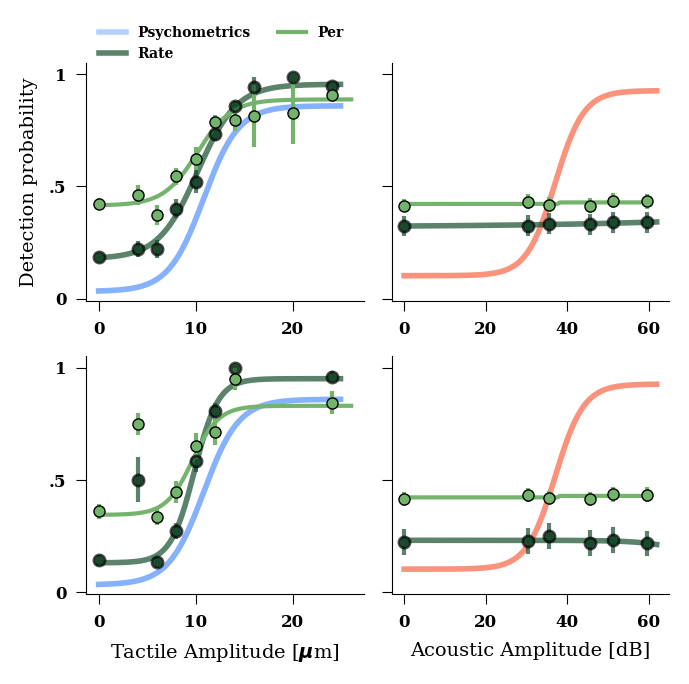

In [20]:
from numpy import arange, divide, inf
import numpy as np
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 6, 'font.weight':'bold', 'font.style':'normal'})
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'
#colors = iter([plt.cm.tab10(i) for i in range(20)])
#colors=list(colors)
colors=((21/255, 77/255, 44/255, 1), (21/255, 77/255, 44/255, 1), (21/255, 77/255, 44/255, 1), 
        (21/255, 77/255, 44/255, 1))
colorsPsic=((47/255, 121/255, 255/255, .35), (249/255, 68/255, 29/255, .35))
def linear(X, a, b):
    return a*X + b

def prom(xvalues, yvalues):
    """
    
    Obtiene el promedio de y para cada xvalue y devuelve ambos vectores.
    """
    x=np.unique(xvalues)
    xval=x
    yval=np.zeros_like(xval)
    yerr=np.zeros_like(yval)
    for idx, x_i in enumerate(xval):
        pos=np.where(xvalues==x_i)[0]
        yval[idx]=np.mean(yvalues[pos])
        yerr[idx]=np.std(yvalues[pos], ddof=1)/np.sqrt(len(pos))
    return xval, yval, yerr 

def fitmatlab(x):
    from numpy import log
    x_new=np.zeros_like(x)
    x_un=np.unique(x)
    for x_i in x_un:
        if x_i!=0:
            msk=x==x_i
            x_new[msk]= 9.904*log(96.58*x_i+12.75) + 4.749
            
    return x_new

def sigmoidal(X, a, b, c, d):
    from numpy import exp
    return (float(a-b))/(1.0  +exp((float(d)-X.astype(float) )/float(c)) ) +float(b)

sem=( (0.00246629, 0.00934693, 0.00691324, 0.01451257, 0.02006645, 0.01941001,
 0.01409271, 0.01369306, 0.01104145, 0.00734865), (0.00874612, 0.01343072, 0.02503005, 0.01562574,
                                                   0.01634785, 0.00927031))

Amplitudes=((0, 6, 10, 12, 14,  24), 
           (0, 30.40014333689977, 35.54467624793413, 45.4695870486123, 51.24204871464509, 59.598553937113024))

Probabilidad= ((0.03478068, 0.07207793,  0.3787323,  0.6236949, 0.76813,  0.85555553, 0.880889),
               (0.10158765, 0.11113491, 0.60050005, 0.84984124, 0.8971112,  0.94905555))

paramspsic=((  0.859070, 0.032516, 1.809071, 10.807832),
            (0.9268,  0.1026, 3.5,  37.01596 ))

paramsperiodicidad={"color":(115/255,179/255, 107/255, 1), "mec":'black', "fmt":'o', "ms":4,
                    "ecolor":(115/255,179/255, 107/255, 1), "ms":4, "mew":0.5}


xx=(arange(0, 25, 0.1), arange(0, 62, 0.1))
cm=1/2.54
fig, ax=plt.subplots(2, 2, figsize=(8.7*cm, 8.7*cm), sharey=True)    # Figura creada

CR_end=1
last_alpha=0.6
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
## Graficación de la psicofísica en cada cuadrante de la figura
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
for modality in range(2):   # 0 tactile, 1 acoustic
    ax[0, modality].plot(xx[modality], sigmoidal(xx[modality], paramspsic[modality][0], paramspsic[modality][1], paramspsic[modality][2], 
                                                   paramspsic[modality][3]), color=colorsPsic[modality], label="Psychometrics", lw=2)
    ax[1, modality].plot(xx[modality], sigmoidal(xx[modality], paramspsic[modality][0], paramspsic[modality][1], paramspsic[modality][2], 
                                                   paramspsic[modality][3]), color=colorsPsic[modality], lw=2)
    ax[0, modality].plot(xx[modality], sigmoidal(xx[modality], paramspsic[modality][0], paramspsic[modality][1], paramspsic[modality][2], 
                                                   paramspsic[modality][3]), color=colorsPsic[modality], lw=2)
    ax[1, modality].plot(xx[modality], sigmoidal(xx[modality], paramspsic[modality][0], paramspsic[modality][1], paramspsic[modality][2], 
                                                   paramspsic[modality][3]), color=colorsPsic[modality], lw=2)
RF=1

for area in (1, 0):
    #Ciclo que va a ir barriendo por area 3b o area 1
    if RF==3:
        maskTCR=neu_tac[:, 2]>=RF
        maskarea=neu_tac[:, 1]==area
        maskACR=neu_acus[:, 2]>=RF
        maskarea=neu_acus[:, 1]==area
    else:
        maskTCR=neu_tac[:, 2]==RF
        maskareaT=neu_tac[:, 1]==area
        maskACR=neu_acus[:, 2]==RF
        maskareaA=neu_acus[:, 1]==area
    # Grafica los puntos con una desviación estándar
    for modality in range(2):   # 0 tactile, 1 acoustic
        if modality==0:    # Tactile stimuli
            pmod=(0.7, 0.1, 0.1, 9)
            boundsmod=((0.2, -0.1, -100, 5), (inf))
            xvalues=neu_tac[maskTCR*maskareaT, 0]
            yvalues=neu_tac[maskTCR*maskareaT, -1]
        else:              # Acoustic stimuli
            pmod=(0.8, 0.1, 0.1, 30)
            boundsmod=((0.1, -0.1, -100, 5), (inf))
            xvalues=neu_acus[maskACR*maskareaA, 0]
            yvalues=neu_acus[maskACR*maskareaA, -1]          
        ## Ajuste sigmoidal
        params, cov=sp.optimize.curve_fit(sigmoidal, xdata=xvalues, ydata=yvalues,  p0=pmod, bounds=boundsmod, maxfev=10000) 
        print("RF={RF} modalidad: {modality}, 3b?:{area}".format(RF=RF, modality=modality, area=area))
        print(params)
        ax[area, modality].plot(xx[modality], sigmoidal(xx[modality], *params), lw=2, 
                            color=colors[RF], label="Rate", alpha=0.7)   
        xmean, ymean, yerr= prom(xvalues, yvalues)       
        ax[area, modality].errorbar(xmean, ymean, yerr,
                                        color=colors[RF], mec='black', fmt='o', ms=4, alpha=0.7)
        ax[area, modality].scatter(xmean, ymean, color=colors[RF], edgecolors="black", alpha=0.7, s=4)
             
for ax_i in ax.flatten():
    ax_i.set_yticks(ticks=(0, 0.5, 1))
    ax_i.set_yticklabels(("0", ".5", "1"))
    ax_i.spines["top"].set_visible(False)
    ax_i.spines["bottom"].set_linewidth(0.4)
    ax_i.spines["left"].set_linewidth(0.4)
    ax_i.spines["top"].set_visible(False)
    ax_i.spines["right"].set_visible(False)  
    ax_i.xaxis.set_tick_params(width=0.4)
    ax_i.yaxis.set_tick_params(width=0.4)
ax[-1, 0].set_xlabel("Tactile Amplitude [$\mu$m]", fontsize=7)
ax[-1, 1].set_xlabel("Acoustic Amplitude [dB]", fontsize=7)
ax[0, 0].set_ylabel("Detection probability", fontsize=7)
# ==========================================================================
# ==========================================================================
# ==========================================================================
#                         Ahora para la periodicidad
# ==========================================================================
# ==========================================================================
# ==========================================================================
maskCR1=Caracteristicas[:, 1]==1

xTCR1=AmpT_Neu[maskCR1, :].flatten()
xACR1=AmpA_Neu[maskCR1, :].flatten()
NeuTCR1=NeuPerT[maskCR1, :].flatten()
xsim=np.linspace(0, 26, 250)
xsimA=np.linspace(0, 60, 250)

# Extraer las medias por amplitud así como las sigmas
yACR=np.zeros((6), dtype=np.float32)
yerrACR=np.zeros((6), dtype=np.float32)
yTCR=np.zeros((20), dtype=np.float32)
yerrTCR=np.zeros((20), dtype=np.float32)

NeuACR=NeuACR1
NeuTCR=NeuTCR1
xTCR=xTCR1
xACR=xACR1  
c=0
for amp_i in np.unique(xTCR):
    mask=xTCR==amp_i
    yTCR[c]=np.mean(NeuTCR[mask])
    yerrTCR[c]=np.std(NeuTCR[mask])/np.sqrt(np.sum(mask))
    c+=1
yTCR=yTCR[0:c]
yerrTCR=yTCR[0:c]    
c=0
for amp_i in np.unique(xACR):
    mask=xACR==amp_i
    yACR[c]=np.mean(NeuACR[mask])
    yerrACR[c]=np.std(NeuACR[mask])/np.sqrt(np.sum(mask))
    c+=1

yACR=yTCR[0:c]
yerrACR=yTCR[0:c]
# maskCR1_3b=np.logical_and(Caracteristicas[:, 1]==1, Caracteristicas[:, -1]==1)
# maskCR1_1 =np.logical_and(Caracteristicas[:, 1]==1, Caracteristicas[:, -1]==0)

for area_i in range(2):
    maskarea=Caracteristicas[:, -1]==area_i
    # Ahora a extraer los elementos en la componente
    xTCR1=AmpT_Neu[maskCR1*maskarea, :].flatten()
    NeuTCR1=NeuPerT[maskCR1*maskarea, :].flatten()
    print(area_i, "xdata: ", len(xTCR1.flatten()))
    print(area_i, "ydata: ", len(NeuTCR1.flatten()))
    #raise Exception("Vale...")

    pmod=(0.7, 0.1, 0.1, 9)
    boundsmod=((0.2, -0.1, -100, 5), (1, 1, np.inf, 25))
    paramsCR1, covparamsCR1=curve_fit(sigmoidal, xdata=xTCR1, ydata=NeuTCR1, p0=pmod, bounds=boundsmod)
    xmean, ymean, yerr=prom(xTCR1, NeuTCR1)
    ax[area_i, 0].errorbar(xmean, ymean, yerr,  **paramsperiodicidad)
    ax[area_i, 0].plot(xsim, sigmoidal(xsim, *paramsCR1), color=(115/255,179/255, 107/255, 1), label="Per")
    xnew=fitmatlab(xACR1)
    paramsCR1, covparamsCR1=curve_fit(sigmoidal, xdata=xnew, ydata=NeuACR1, p0=pmod, bounds=boundsmod)
    xmean, ymean, yerr=prom(xnew, NeuACR1)
    ax[area_i, 1].errorbar(xmean, ymean, yerr,   **paramsperiodicidad)
    ax[area_i, 1].plot(xsimA, sigmoidal(xsimA, *paramsCR1A), color=(115/255,179/255, 107/255, 1))
    ax[area_i,0].set_ylim([-0.01, 1.05])
    ax[0, 0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.21), frameon=False,
          ncol=2, fancybox=False, shadow=False, fontsize=5)
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
#     plt.savefig("PsicofNeurom_PerTasaCR_13b_1.svg", format="svg")

ValueError: operands could not be broadcast together with shapes (486,4) (6,) 

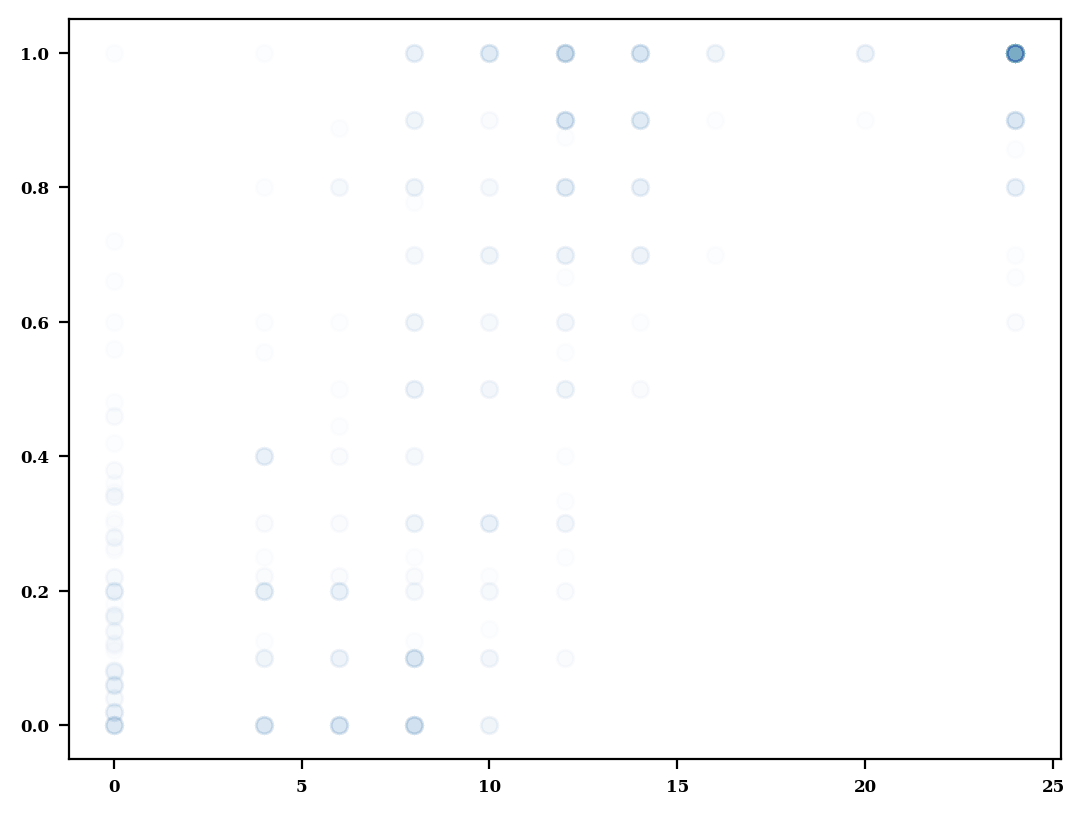

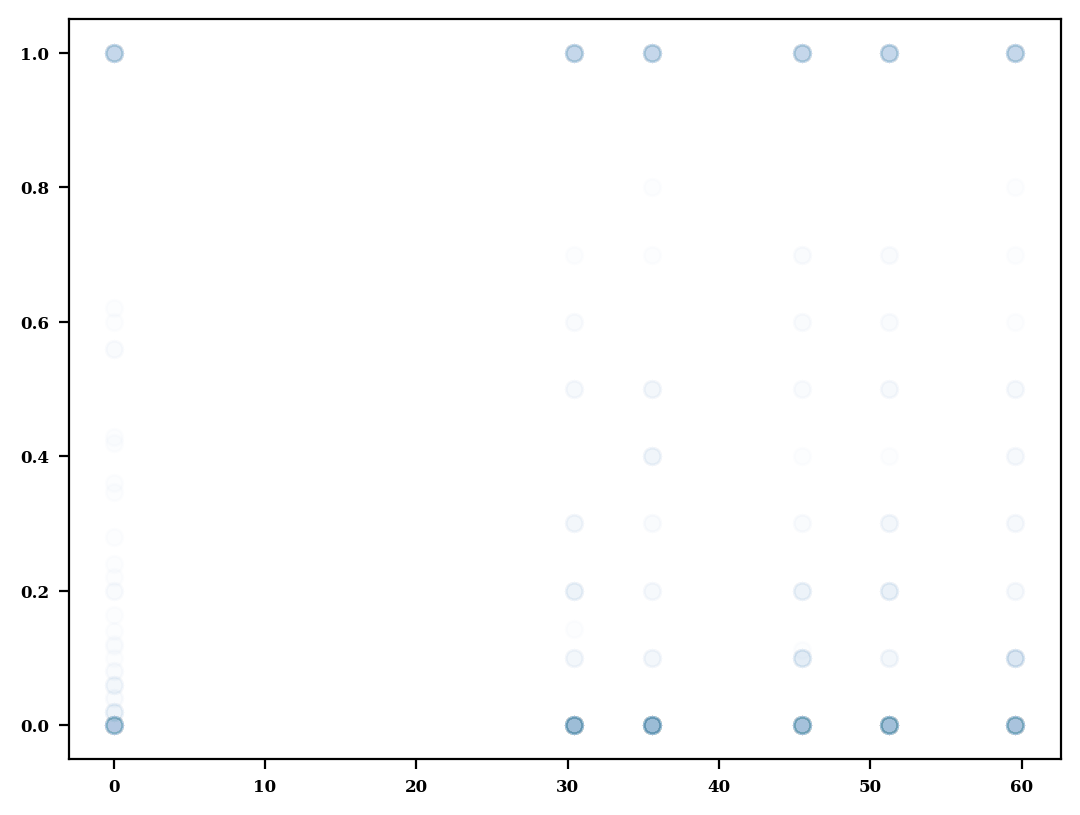

In [44]:
for modality in range(2):
    if modality==0:    # Tactile stimuli
        xvalues=neu_tac[maskTCR*maskareaT, 0]
        yvalues=neu_tac[maskTCR*maskareaT, -1]
    else:              # Acoustic stimuli

        xvalues=neu_acus[maskACR*maskareaA, 0]
        yvalues=neu_acus[maskACR*maskareaA, -1]   
    plt.figure()
    plt.scatter(xvalues, yvalues, alpha=0.01)
np.allclose(neu_acus[maskACR*maskareaA], np.array([1, 0,0,0,0,0]))

## Scatter plot d prime

In [48]:
msk1=np.logical_and(xvalues>0, yvalues==1)
msk0=np.logical_and(xvalues>0, yvalues==0)
print("1: ", np.sum(msk1), " 0: ", np.sum(msk0))


1:  98  0:  189


In [51]:
19/(19+38)

0.3333333333333333

# Información de periodicidad


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import Extensiones as Pext
from lfpy import Spectrogram
# Bloque de código
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from numba import njit
import Extensiones as Pext
from scipy.signal.windows import tukey
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time

fs=100             # Frecuencia de muestreo
width=0.200        # segundos. 
t_ext=(-1.7, 2.5)  # Extremos del intervalo a analizar.
nperm=10000        # Número de permutaciones

R32=np.loadtxt("/home/sparra/MEGA/Prjl/S1_Inc_RR032.csv", delimiter=",", usecols=(0,2,3,4,6,9), skiprows=1)
R33=np.loadtxt("/home/sparra/MEGA/Prjl/S1_Inc_RR033.csv", delimiter=",", usecols=(0,2,3,4,6,9), skiprows=1)
R=np.concatenate((R32, R33), axis=0)
del R32, R33

NeuPerT=np.zeros((len(R), 6), dtype=np.float64)
NeuPerA=np.zeros((len(R), 6), dtype=np.float64)
AmpT_Neu=np.zeros((len(R), 6), dtype=np.float64)
AmpA_Neu=np.zeros((len(R), 6), dtype=np.float64)
Caracteristicas=np.zeros((350*150, 4), dtype=np.float64)
bloque=0
row=0
Periodicidad_acum=[]
Informacion_Tac=[]
p099=[]
p095=[]
car=[]
Informacion_Acus=[]
p099A=[]
p095A=[]
posi=[]
for arc in range(len(R)):#len(R)
    Periodicidad2=[]
    #mono, serie, orden, elec, uni= (32, 164, 2, 5, 1)
    serie,  elec, uni, orden= R[arc, (0, 1, 2, 3)]
    if serie>100:
        mono=32
    else:
        mono=33
    try:
        times, psyc, spikesshort=loaddata(serie, elec, uni, orden, t_ext)
    except Exception as err:
        print(err)
        continue
    posi.append([arc])
    ntrials=len(spikesshort)
    tasa_serie=[]
    for trial_i in range(ntrials):
        tmp=spikesshort[trial_i]-t_ext[0]
        try:
            tasa=Pext.FRcausalR(tmp, 0.025, fs, 0, t_ext[1] -t_ext[0])
        except:
            #print("La longitud de las espigas es: ", len(tmp),"\t", tmp)
            tasa=np.arange(t_ext[0], t_ext[1], 1/100)*0
        tasa_serie.append(tasa)
    Caracteristicas[bloque: bloque + len(psyc), 0]=R[arc, 4]    # cr
    Caracteristicas[bloque: bloque + len(psyc), 1]=R[arc, 5]    # 3b
    Caracteristicas[bloque: bloque + len(psyc), 2]=np.sum(psyc[:, (11, 13)], axis=1)  # Amplitud
    bloque+=len(psyc)
    tasa_serie=np.vstack(tasa_serie)
    tasa_serie=(tasa_serie - np.mean(tasa_serie))/(np.std(tasa_serie))     # Normalizamos para el cálculo de tasa
    for trial_i in range(ntrials):
        hz, t, TF=Spectrogram(tasa_serie[trial_i], fs, width, noverlap=0.80, plotting=False, window=())
        pos, pos2=np.argmin(np.abs(hz-18)), np.argmin(np.abs(hz-22))
        Periodicidad2.append(np.sum(TF[pos : pos2 + 1, :], axis=0))
        #break
    # Cálculo de la información de periodicidad
    maskA=np.where(psyc[:, 13]>0)[0]
    maskZ=np.where((psyc[:, 13]==0)*(psyc[:, 11]==0))[0]
    maskT=np.where(psyc[:, 11]>0)[0]
    tmp=np.concatenate((maskZ, maskT))
    nbins=8
    ampT, PsT=calculate_probstim(psyc[tmp, 11])  
    Periodicidad2=np.vstack(Periodicidad2)
    Periodicidad_acum.append(Periodicidad2)
    #Periodicidad1=np.vstack(Periodicidad1)
    minT=np.min(Periodicidad2)
    maxT=np.max(Periodicidad2)    
    BinEdgesT=np.linspace(minT, maxT, nbins + 1)
    I_t=Inf_time(Periodicidad2[tmp, :], np.size(Periodicidad2, axis=1), 
                 BinEdgesT, psyc[tmp, 11], ampT, PsT, nbins)
    # Ahora vienen las múltiples comparaciones
    I_t_perm=np.zeros((nperm, 100))
    tmp2=np.copy(tmp)
    for perm_i in range(nperm):
        np.random.shuffle(tmp2)
        I_t_perm[perm_i, :]=Inf_time(Periodicidad2[tmp2, :], np.size(Periodicidad2, axis=1), 
                 BinEdgesT, psyc[tmp, 11], ampT, PsT, nbins)
    
    Informacion_Tac.append(I_t - np.mean(I_t_perm, axis=0))
    I_t_perm.sort(axis=0)
    p099.append(I_t>=I_t_perm[np.int32(0.99*nperm),:])
    p095.append(I_t>=I_t_perm[np.int32(0.95*nperm),:])
    # Repetir para el caso acústico
    tmp=np.concatenate((maskZ, maskA))
    nbins=8
    ampT, PsT=calculate_probstim(psyc[tmp, 13])  
    minT=np.min(Periodicidad2[tmp])
    maxT=np.max(Periodicidad2[tmp])    
    BinEdgesT=np.linspace(minT, maxT, nbins + 1)
    I_t=Inf_time(Periodicidad2[tmp, :], np.size(Periodicidad2, axis=1), 
                 BinEdgesT, psyc[tmp, 11], ampT, PsT, nbins)
    # Ahora vienen las múltiples comparaciones
    I_t_perm=np.zeros((nperm, 100))
    tmp2=np.copy(tmp)
    for perm_i in range(nperm):
        np.random.shuffle(tmp2)
        I_t_perm[perm_i, :]=Inf_time(Periodicidad2[tmp2, :], np.size(Periodicidad2, axis=1), 
                 BinEdgesT, psyc[tmp, 13], ampT, PsT, nbins)
    
    Informacion_Acus.append(I_t - np.mean(I_t_perm, axis=0))
    I_t_perm.sort(axis=0)
    p099A.append(I_t>I_t_perm[np.int32(0.99*nperm),:])
    p095A.append(I_t>I_t_perm[np.int32(0.95*nperm),:])
print("Finalizado...")


could not convert string to float: ''
could not convert string to float: ''
could not convert string to float: ''
could not convert string to float: ''
could not convert string to float: ''
could not convert string to float: ''
El archivo /home/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032165_002/RR032165_002_e7_u3.csv no existe
cannot unpack non-iterable int object
El archivo /home/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032167_002/RR032167_002_e7_u1.csv no existe
cannot unpack non-iterable int object
El archivo /home/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032168_002/RR032168_002_e7_u1.csv no existe
cannot unpack non-iterable int object
El archivo /home/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032168_002/RR032168_002_e7_u2.csv no existe
cannot unpack non-iterable int object
El archivo /home/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032169_002/RR032169_002_e7_u1.csv no existe
cannot unpack non-iterable int object
El archivo /

Finalizado...


In [9]:
import pickle as pkl

file1=open("InformacionPeriodicidadFourierT.pkl", "wb")
DatosaGuardar={"p095":p095, "p099":p099, "InformacionT":np.vstack(Informacion_Tac), "Periodicidad":Periodicidad_acum,
              "Caracteristicas":Caracteristicas[0:bloque, :], "propertiesp":R[np.array(posi), (4, 5)], 
               "t_I":t + t_ext[0]+ 0.10}
pkl.dump(DatosaGuardar, file1, protocol=5)
file1.close()
file1=open("InformacionPeriodicidadFourierA.pkl", "wb")
DatosaGuardar={"p095":p095A, "p099":p099A, "InformacionA":np.vstack(Informacion_Acus), "Periodicidad":Periodicidad_acum,
              "Caracteristicas":Caracteristicas[0:bloque, :], "propertiesp":R[np.array(posi), (4, 5)], 
               "t_I":t + t_ext[0]+ 0.10}
pkl.dump(DatosaGuardar, file1, protocol=5)
file1.close()


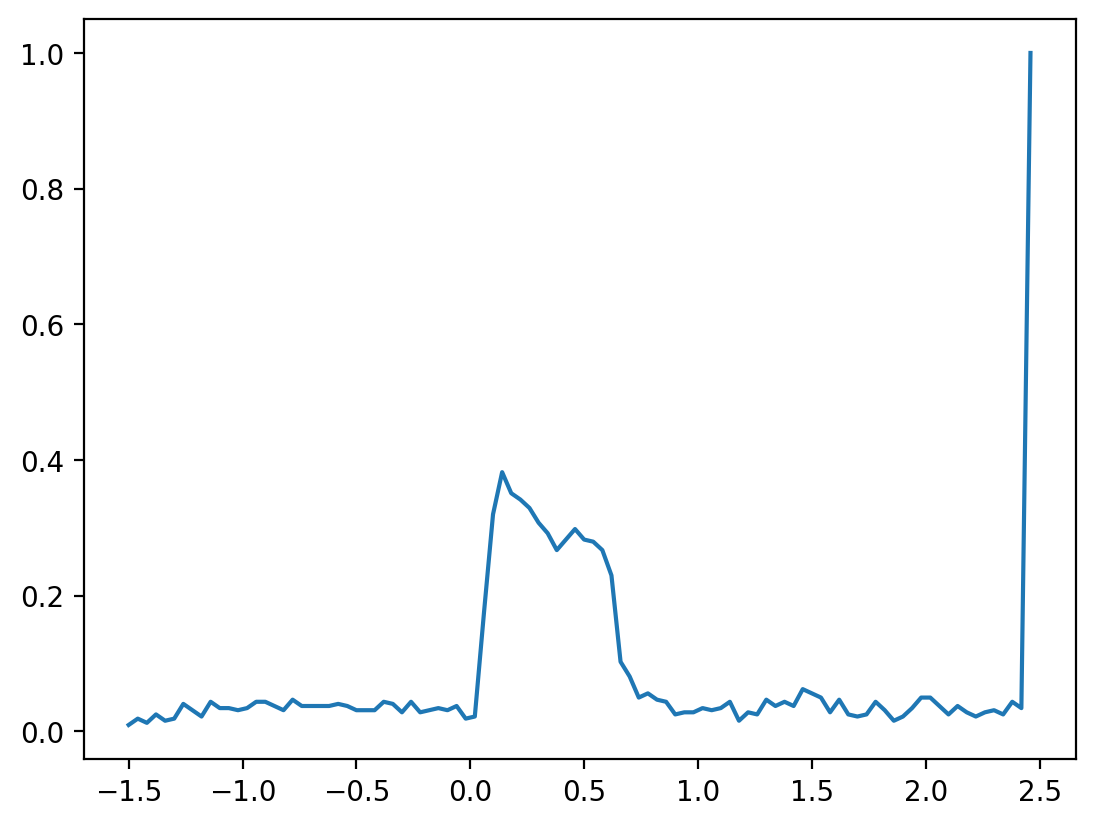

In [10]:
plt.plot(t + t_ext[0]+ 0.10, np.mean(p099, axis=0))

# Información poblacional de periodicidad


In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())
print("keys IA: ", IA.keys())

fs=100             # Frecuencia de muestreo
width=0.200        # segundos. 
stp=0.05*width     # segundos
t_ext=(-1.7, 2.5)  # Extremos del intervalo a analizar.
nperm=10000        # Número de permutaciones

print(len(IT["propertiesp"]) )

(IT["propertiesp"][:, 0]>2).any


keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
322


<function ndarray.any>

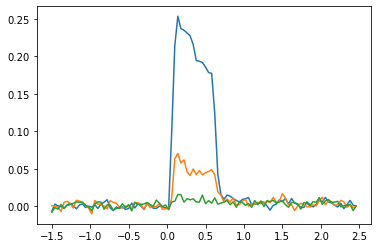

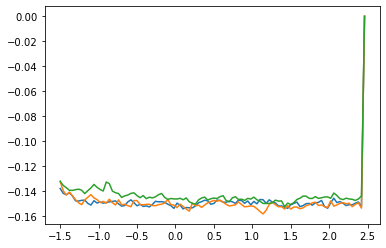

In [2]:
mask=IT["propertiesp"][:, 0]==1
mask2=IT["propertiesp"][:, 0]==2
mask3=IT["propertiesp"][:, 0]>2

#plt.plot(IT["t_I"], np.mean(IT["InformacionT"][mask, :], axis=0))
I_t=np.vstack(IT["InformacionT"])
plt.plot(IT["t_I"], np.mean(I_t[mask, :], axis=0))
plt.plot(IT["t_I"], np.mean(I_t[mask2, :], axis=0))
plt.plot(IT["t_I"], np.mean(I_t[mask3, :], axis=0))
plt.figure()
I_a=np.vstack(IA["InformacionA"])
maskA=IA["propertiesp"][:, 0]==1
maskA2=IA["propertiesp"][:, 0]==2
maskA3=IA["propertiesp"][:, 0]>2
plt.plot(IA["t_I"], np.mean(I_a[mask, :], axis=0))
plt.plot(IA["t_I"], np.mean(I_a[mask2, :], axis=0))
plt.plot(IA["t_I"], np.mean(I_a[mask3, :], axis=0))

In [ ]:
mask=IT["propertiesp"][:, 0]==1      # RF: 1
mask2=IT["propertiesp"][:, 0]==2     # RF: 2
mask3=IT["propertiesp"][:, 0]>2      # Rf: 3

#plt.plot(IT["t_I"], np.mean(IT["InformacionT"][mask, :], axis=0))
idx=np.where(np.logical_and(IT["t_I"]>=0.1, IT["t_I"]<=0.6 ))[0]
I_t=np.vstack(IT["InformacionT"])
np.histogram()
plt.plot(IT["t_I"], np.mean(I_t[mask, :], axis=0))
plt.plot(IT["t_I"], np.mean(I_t[mask2, :], axis=0))
plt.plot(IT["t_I"], np.mean(I_t[mask3, :], axis=0))
plt.figure()
I_a=np.vstack(IA["InformacionA"])
maskA=IA["propertiesp"][:, 0]==1
maskA2=IA["propertiesp"][:, 0]==2
maskA3=IA["propertiesp"][:, 0]>2
plt.plot(IA["t_I"], np.mean(I_a[mask, :], axis=0))
plt.plot(IA["t_I"], np.mean(I_a[mask2, :], axis=0))
plt.plot(IA["t_I"], np.mean(I_a[mask3, :], axis=0))

In [5]:
import numpy as np
np.histogram?

# Información de periodicidad poblacional

Esta parte vuelve a ser independiente de las anteriores. Utiliza los datos guardados en las anteriores celdas 
para obtener la potencia a 20 Hz o bien periodicidad.

In [13]:
# Bloque de código
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from numba import njit
import Extensiones as Pext
from scipy.signal.windows import tukey
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())
print("keys IA: ", IA.keys())

keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])


<ErrorbarContainer object of 3 artists>

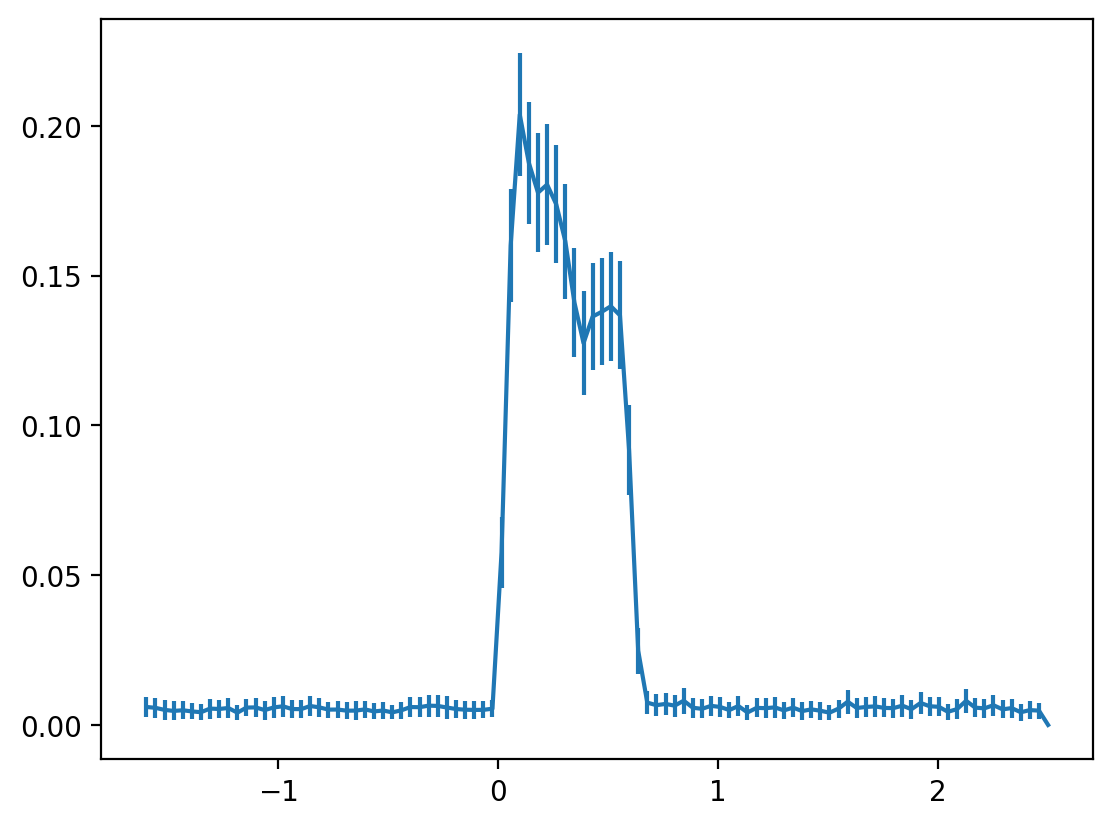

In [14]:
MaskCR1=IT["Caracteristicas"][:, 0]==1  # CR
maskT=(IT["Caracteristicas"][MaskCR1, 2]==0)+(IT["Caracteristicas"][MaskCR1, 2]>3)
amplitudes=IT["Caracteristicas"][MaskCR1, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR1, :]
periodicidad=periodicidad[maskT, :]

ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_tCR1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins)

I_t_CR1_bootstrap=np.zeros((nperm, len(I_tCR1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_t_CR1_bootstrap[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_t_CR1_bootstrap, axis=0), 3*np.std(I_t_CR1_bootstrap, axis=0))

In [15]:
# Guardado del resultado
np.save("PotenciaInfCR1Tactile_boot.npz", I_t_CR1_bootstrap)
print("PotenciaInfCR1Tactile_boot.npz \t archivo creado")

PotenciaInfCR1Tactile_boot.npz 	 archivo creado


In [16]:
MaskCR1=IA["Caracteristicas"][:, 0]==1  # CR
maskA=IA["Caracteristicas"][MaskCR1, 2]<3
amplitudes=IA["Caracteristicas"][MaskCR1, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR1, :]
periodicidad=periodicidad[maskA, :]

nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR1_bootstrap=np.zeros((nperm, len(I_ACR1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    amp_Ai, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR1_bootstrap[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_A_CR1_bootstrap, axis=0), 3*np.std(I_A_CR1_bootstrap, axis=0))

# Guardado del resultado
np.save("PotenciaInfCR1Acoustic_boot.npz", I_A_CR1_bootstrap)
print("PotenciaInfCR1Acoustic_boot.npz \t archivo creado")

NameError: name 'ampA_i' is not defined

In [ ]:
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_t_CR1_bootstrap, axis=0), 3*np.std(I_t_CR1_bootstrap, axis=0))
plt.figure()
plt.hist(I_t_CR1_bootstrap[:, 48])

### Campo receptor 2 Ahora la separación por áreas información acústica

keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr2 área S1->3b
Se realizarán 29084 submuestreos por bootstrap 12652249
Cálculo de permutaciones, para el cr2 área S1->3b
Se realizarán 29084 permutaciones 10000
PotenciaInfCR1Acoustic_BootPerm_3b.npy 	 archivo creado


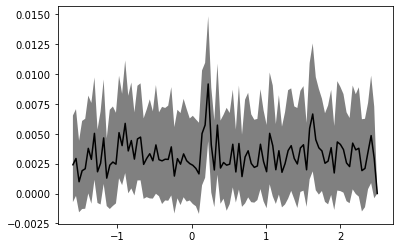

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())

MaskCR2=(IA["Caracteristicas"][:, 0]==1)*(IA["Caracteristicas"][:, 1]==1)  # CR1 3b
maskA=(IA["Caracteristicas"][MaskCR2, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
#nperm=100    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR2_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR2_bootstrap_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR2_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR2_Perm_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR2_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR2_bootstrap_3b, axis=0)- np.mean(I_A_CR2_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":1, "mono":(32, 33), "modalidad":"acústica", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_A_CR2_bootstrap_3b, "Permutaciones": I_A_CR2_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR1Acoustic_BootPerm_3b.npy", Datos)
print("PotenciaInfCR1Acoustic_BootPerm_3b.npy \t archivo creado")


keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr2 área S1->1
Se realizarán 64720 submuestreos por bootstrap 52969284
Cálculo de permutaciones, para el cr2 área S1->1
Se realizarán 64720 permutaciones 10000
PotenciaInfCR1Acoustic_BootPerm_1.npy 	 archivo creado


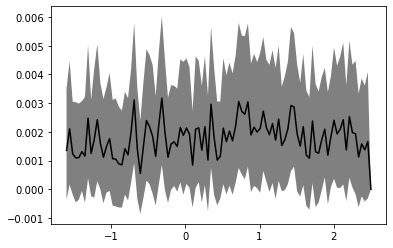

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())

MaskCR2=(IA["Caracteristicas"][:, 0]==1)*(IA["Caracteristicas"][:, 1]==0)  # CR1 1
maskA=(IA["Caracteristicas"][MaskCR2, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
#nperm=100    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR2_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR2_bootstrap_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR2_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR2_Perm_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR2_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR2_bootstrap_3b, axis=0)- np.mean(I_A_CR2_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"1", "RF":1, "mono":(32, 33), "modalidad":"acústica", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_A_CR2_bootstrap_3b, "Permutaciones": I_A_CR2_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR1Acoustic_BootPerm_1.npy", Datos)
print("PotenciaInfCR1Acoustic_BootPerm_1.npy \t archivo creado")


## Modalidad vibrotáctil CR1

keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr2 área S1->3b
Se realizarán 28763 submuestreos por bootstrap 12404484
Cálculo de permutaciones, para el cr1 área S1->3b
Se realizarán 10000 permutaciones 10000
PotenciaInfCR1Tactile_BootPerm_3b.npy : 	 archivo creado


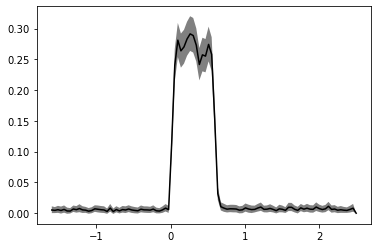

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl
from datetime import date


file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())


MaskCR1=(IT["Caracteristicas"][:, 0]==1)*(IT["Caracteristicas"][:, 1]==1)  # CR1 3b
maskT=(IT["Caracteristicas"][MaskCR1, 2]>3) + (IT["Caracteristicas"][MaskCR1, 2]==0)
amplitudes=IT["Caracteristicas"][MaskCR1, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR1, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR1_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR1_bootstrap_3b=np.zeros((nperm, len(I_TCR1_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR1_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr1 área S1->3b")
nperm=10000 #00#np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR1_Perm_3b=np.zeros((nperm, len(I_TCR1_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR1_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR1_bootstrap_3b-np.mean(I_T_CR1_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR1_bootstrap_3b-np.mean(I_T_CR1_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR1_bootstrap_3b, axis=0)- np.mean(I_T_CR1_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":1, "mono":(32, 33), "modalidad":"Táctil", "fecha":"20-Oct-2021"}
Datos={"Bootstrap":I_T_CR1_bootstrap_3b, "Permutaciones": I_T_CR1_Perm_3b, "t":t_ext, "metadata":metadata}
namefile="PotenciaInfCR1Tactile_BootPerm_3b.npy"
np.save(namefile, Datos)
print(namefile, ": \t archivo creado")


keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr1 área S1->1
Se realizarán 64433 submuestreos por bootstrap 52548001
Cálculo de permutaciones, para el cr1 área S1->3b
Se realizarán 10000 permutaciones 10000
PotenciaInfCR1Tactile_BootPerm_1.npy : 	 archivo creado


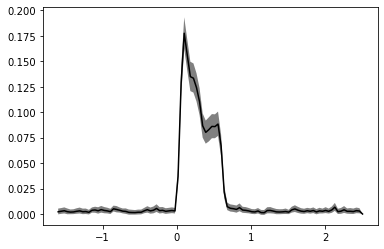

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl
from datetime import date


file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())


MaskCR1=(IT["Caracteristicas"][:, 0]==1)*(IT["Caracteristicas"][:, 1]==0)  # CR1 1
maskT=(IT["Caracteristicas"][MaskCR1, 2]>3) + (IT["Caracteristicas"][MaskCR1, 2]==0)
amplitudes=IT["Caracteristicas"][MaskCR1, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR1, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr1 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR1_1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR1_bootstrap_1=np.zeros((nperm, len(I_TCR1_1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR1_bootstrap_1[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr1 área S1->3b")
nperm=10000 #00#np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR1_Perm_1=np.zeros((nperm, len(I_TCR1_1)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR1_Perm_1[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR1_bootstrap_1-np.mean(I_T_CR1_Perm_1, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR1_bootstrap_1-np.mean(I_T_CR1_Perm_1, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR1_bootstrap_1, axis=0)- np.mean(I_T_CR1_Perm_1, axis=0), color="k")

# Guardado del resultado
metadata={"area":"1", "RF":1, "mono":(32, 33), "modalidad":"Táctil", "fecha":str(date.today())}
Datos={"Bootstrap":I_T_CR1_bootstrap_1, "Permutaciones": I_T_CR1_Perm_1, "t":t_ext, "metadata":metadata}
namefile="PotenciaInfCR1Tactile_BootPerm_1.npy"
np.save(namefile, Datos)
print(namefile, ": \t archivo creado")


## Campo receptor 2

In [3]:
MaskCR2=IT["Caracteristicas"][:, 0]==2  # CR
maskT=(IT["Caracteristicas"][MaskCR2, 2]==0)+(IT["Caracteristicas"][MaskCR2, 2]>3)
amplitudes=IT["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskT, :]

ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_tCR2=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT)-1)

I_t_CR2_bootstrap=np.zeros((nperm, len(I_tCR2)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_t_CR2_bootstrap[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))
t_ext=np.arange(np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_t_CR2_bootstrap, axis=0), 3*np.std(I_t_CR2_bootstrap, axis=0))
np.save("PotenciaInfCR2Tactile_boot.npz", I_t_CR1_bootstrap)
print("PotenciaInfCR2Tactile_boot.npz \t archivo creado")

KeyboardInterrupt: 

In [ ]:
plt.plot(I_t_CR2_bootstrap[99101, :])

In [ ]:
MaskCR1=IA["Caracteristicas"][:, 0]==2  # CR
maskA=(IA["Caracteristicas"][MaskCR1, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR1, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR1, :]
periodicidad=periodicidad[maskA, :]
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d submuestreos por bootstrap"%(nperm))
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR2=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR2_bootstrap=np.zeros((nperm, len(I_ACR2)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR2_bootstrap[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_A_CR2_bootstrap, axis=0), 3*np.std(I_A_CR2_bootstrap, axis=0))

# Guardado del resultado
#np.save("PotenciaInfCR2Acoustic_boot.npz", I_A_CR2_bootstrap)
print("PotenciaInfCR2Acoustic_boot.npz \t archivo creado")

### Campo receptor 2 Ahora la separación por áreas información acústica

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())

MaskCR2=(IA["Caracteristicas"][:, 0]==2)*(IA["Caracteristicas"][:, 1]==1)  # CR2 3b
maskA=(IA["Caracteristicas"][MaskCR2, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
nperm=100    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR2_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR2_bootstrap_3b=np.zeros((nperm, len(I_ACR3_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR2_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->3b")
nperm=100 #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR2_Perm_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR2_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR2_bootstrap_3b, axis=0)- np.mean(I_A_CR2_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":2, "mono":(32, 33), "modalidad":"acústica", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_A_CR2_bootstrap_3b, "Permutaciones": I_A_CR2_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR2Acoustic_BootPerm_3b.npy", Datos)
print("PotenciaInfCR2Acoustic_BootPerm_3b.npy \t archivo creado")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())


MaskCR3=(IA["Caracteristicas"][:, 0]>2)*(IA["Caracteristicas"][:, 1]==0)  # CR 1
maskA=(IA["Caracteristicas"][MaskCR3, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr3 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
nperm=100    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR3_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR3_bootstrap_3b=np.zeros((nperm, len(I_ACR3_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR3_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr3 área S1->3b")
nperm=100 #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR3_Perm_3b=np.zeros((nperm, len(I_ACR3_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR3_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR3_bootstrap_3b-np.mean(I_A_CR3_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR3_bootstrap_3b-np.mean(I_A_CR3_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR3_bootstrap_3b, axis=0)- np.mean(I_A_CR3_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":3, "mono":(32, 33), "modalidad":"acústica", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_A_CR3_bootstrap_3b, "Permutaciones": I_A_CR3_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR3Acoustic_BootPerm_3b.npy", Datos)
print("PotenciaInfCR3Acoustic_BootPerm_3b.npy \t archivo creado")


## Ahora la modalidad táctil. Campo receptor 2. Separado por áreas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())


MaskCR2=(IA["Caracteristicas"][:, 0]==2)*(IA["Caracteristicas"][:, 1]==1)  # CR 3b
maskA=(IA["Caracteristicas"][MaskCR2, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
#nperm=1000    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR2_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR2_bootstrap_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR2_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->3b")
nperm=10000#np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR2_Perm_3b=np.zeros((nperm, len(I_ACR2_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR2_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR2_bootstrap_3b-np.mean(I_A_CR2_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR2_bootstrap_3b, axis=0)- np.mean(I_A_CR2_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":2, "mono":(32, 33), "modalidad":"acústica", "fecha":"18-Oct-2021"}
Datos={"Bootstrap":I_A_CR2_bootstrap_3b, "Permutaciones": I_A_CR2_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR2Acoustic_BootPerm_3b.npy", Datos)
print("PotenciaInfCR2Acoustic_BootPerm_3b.npy \t archivo creado")


keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr2 área S1->1
Se realizarán 81449 submuestreos por bootstrap 80120401
Cálculo de permutaciones, para el cr2 área S1->1
Se realizarán 10000 permutaciones 10000
PotenciaInfCR2Acoustic_BootPerm_1.npy 	 archivo creado


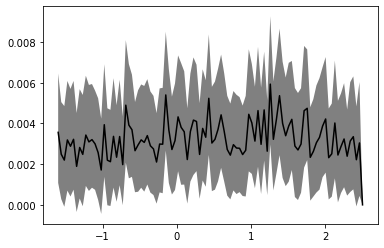

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())


MaskCR2=(IA["Caracteristicas"][:, 0]==2)*(IA["Caracteristicas"][:, 1]==0)  # CR 1
maskA=(IA["Caracteristicas"][MaskCR2, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000

print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
#print("ampl. probabilities", ampA, PsA)

BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
#print("histogramas", BinEdgesA)
I_ACR2_1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR2_bootstrap_1=np.zeros((nperm, len(I_ACR2_1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR2_bootstrap_1[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->1")
nperm=10000   #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR2_Perm_1=np.zeros((nperm, len(I_ACR2_1)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR2_Perm_1[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR2_bootstrap_1-np.mean(I_A_CR2_Perm_1, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR2_bootstrap_1-np.mean(I_A_CR2_Perm_1, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR2_bootstrap_1, axis=0)- np.mean(I_A_CR2_Perm_1, axis=0), color="k")

# Guardado del resultado
metadata={"area":"1", "RF":2, "mono":(32, 33), "modalidad":"acústica", "fecha":"18-Oct-2021"}
Datos={"Bootstrap":I_A_CR2_bootstrap_1, "Permutaciones": I_A_CR2_Perm_1, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR2Acoustic_BootPerm_1.npy", Datos)
print("PotenciaInfCR2Acoustic_BootPerm_1.npy \t archivo creado")


## Ahora la modalidad vibrotáctile. 
## RF=2    Area 3b

keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr2 área S1->3b
Se realizarán 10000 submuestreos por bootstrap 248004
Cálculo de permutaciones, para el cr2 área S1->3b
Se realizarán 1000 permutaciones 10000
PotenciaInfCR2Tactile_BootPerm_3b.npy : 	 archivo creado


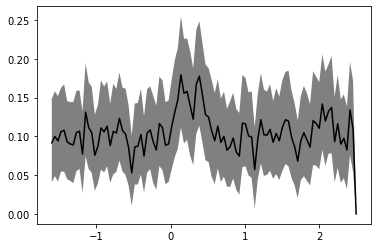

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())


MaskCR2=(IT["Caracteristicas"][:, 0]==2)*(IT["Caracteristicas"][:, 1]==1)  # CR 3b
maskT=(IT["Caracteristicas"][MaskCR2, 2]>3) + (IT["Caracteristicas"][MaskCR2, 2]==0)
amplitudes=IT["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR2_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR2_bootstrap_3b=np.zeros((nperm, len(I_TCR2_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR2_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->3b")
nperm=1000 #00#np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR2_Perm_3b=np.zeros((nperm, len(I_TCR2_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR2_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR2_bootstrap_3b-np.mean(I_T_CR2_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR2_bootstrap_3b-np.mean(I_T_CR2_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR2_bootstrap_3b, axis=0)- np.mean(I_T_CR2_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":2, "mono":(32, 33), "modalidad":"Táctil", "fecha":"18-Oct-2021"}
Datos={"Bootstrap":I_T_CR2_bootstrap_3b, "Permutaciones": I_T_CR2_Perm_3b, "t":t_ext, "metadata":metadata}
namefile="PotenciaInfCR2Tactile_BootPerm_3b.npy"
np.save(namefile, Datos)
print(namefile, ": \t archivo creado")


keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr2 área S1->1
Se realizarán 81237 submuestreos por bootstrap 79744900
Cálculo de permutaciones, para el cr2 área S1->1
Se realizarán 1000 permutaciones 10000
PotenciaInfCR2Tactile_BootPerm_1.npy : 	 archivo creado


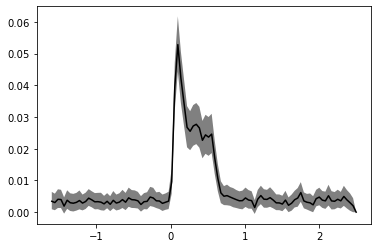

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl


file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())


MaskCR2=(IT["Caracteristicas"][:, 0]==2)*(IT["Caracteristicas"][:, 1]==0)  # CR 3b
maskT=(IT["Caracteristicas"][MaskCR2, 2]>3) + (IT["Caracteristicas"][MaskCR2, 2]==0)
amplitudes=IT["Caracteristicas"][MaskCR2, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR2, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr2 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR2_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR2_bootstrap_3b=np.zeros((nperm, len(I_TCR2_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR2_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr2 área S1->1")
nperm=1000 #00#np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR2_Perm_3b=np.zeros((nperm, len(I_TCR2_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR2_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR2_bootstrap_3b-np.mean(I_T_CR2_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR2_bootstrap_3b-np.mean(I_T_CR2_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR2_bootstrap_3b, axis=0)- np.mean(I_T_CR2_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"1", "RF":2, "mono":(32, 33), "modalidad":"Táctil", "fecha":"18-Oct-2021"}
Datos={"Bootstrap":I_T_CR2_bootstrap_3b, "Permutaciones": I_T_CR2_Perm_3b, "t":t_ext, "metadata":metadata}
namefile="PotenciaInfCR2Tactile_BootPerm_1.npy"
np.save(namefile, Datos)
print(namefile, ": \t archivo creado")


### Campo receptor 3, sin separación

In [ ]:
MaskCR3=IT["Caracteristicas"][:, 0]>2  # CR
maskT=(IT["Caracteristicas"][MaskCR3, 2]==0)+(IT["Caracteristicas"][MaskCR3, 2]>3)
amplitudes=IT["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskT, :]

ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_tCR3=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins)

I_t_CR3_bootstrap=np.zeros((nperm, len(I_tCR3)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_t_CR3_bootstrap[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))
t_ext=np.arange(np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_t_CR3_bootstrap, axis=0), 3*np.std(I_t_CR3_bootstrap, axis=0))
np.save("PotenciaInfCR3Tactile_boot.npz", I_t_CR1_bootstrap)
print("PotenciaInfCR3Tactile_boot.npz \t archivo creado")

In [ ]:
## Caso acústico

MaskCR3=IA["Caracteristicas"][:, 0]>2  # CR
maskA=(IA["Caracteristicas"][MaskCR3, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskA, :]

nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d submuestreos por bootstrap"%(nperm))
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR3=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR3_bootstrap=np.zeros((nperm, len(I_ACR3)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR3_bootstrap[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))
plt.errorbar(t_ext, np.mean(I_A_CR3_bootstrap, axis=0), 3*np.std(I_A_CR3_bootstrap, axis=0))

# Guardado del resultado
np.save("PotenciaInfCR3Acoustic_boot.npz", I_A_CR3_bootstrap)
print("PotenciaInfCR3Acoustic_boot.npz \t archivo creado")

### Campo receptor 3 Ahora la separación por áreas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())
print("keys IA: ", IA.keys())


MaskCR3=(IA["Caracteristicas"][:, 0]>2)*(IA["Caracteristicas"][:, 1]==1)  # CR 3b
maskA=(IA["Caracteristicas"][MaskCR3, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr3 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
I_ACR3_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR3_bootstrap_3b=np.zeros((nperm, len(I_ACR3_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR3_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr3 área S1->3b")
nperm=10000 #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR3_Perm_3b=np.zeros((nperm, len(I_ACR3_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR3_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR3_bootstrap_3b-np.mean(I_A_CR3_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR3_bootstrap_3b-np.mean(I_A_CR3_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR3_bootstrap_3b, axis=0)- np.mean(I_A_CR3_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":3, "mono":(32, 33), "modalidad":"acústica", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_A_CR3_bootstrap_3b, "Permutaciones": I_A_CR3_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR3Acoustic_BootPerm_3b.npy", Datos)
print("PotenciaInfCR3Acoustic_BootPerm_3b.npy \t archivo creado")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl

file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())

MaskCR3=(IA["Caracteristicas"][:, 0]>2)*(IA["Caracteristicas"][:, 1]==0)  # CR 3 area 1
maskA=(IA["Caracteristicas"][MaskCR3, 2]<3)
amplitudes=IA["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskA]
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskA, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr3 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000   
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampA, PsA=calculate_probstim(amplitudes)  
print("Las amplitudes son:", ampA)   
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='auto')
I_ACR3_1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, nbins=len(BinEdgesA))

I_A_CR3_bootstrap_1=np.zeros((nperm, len(I_ACR3_1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampA_i, PsA_i=calculate_probstim(amplitudes[indices_i])  
    I_A_CR3_bootstrap_1[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes[indices_i], ampA_i, PsA_i, len(BinEdgesA))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr3 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_A_CR3_Perm_1=np.zeros((nperm, len(I_ACR3_1)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_A_CR3_Perm_1[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesA, amplitudes, ampA, PsA, len(BinEdgesA))
  
    
## Graficación 
inf=np.quantile(I_A_CR3_bootstrap_1-np.mean(I_A_CR3_Perm_1, axis=0), q=0.025, axis=0)
sup=np.quantile(I_A_CR3_bootstrap_1-np.mean(I_A_CR3_Perm_1, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_A_CR3_bootstrap_1, axis=0)- np.mean(I_A_CR3_Perm_1, axis=0), color="k")

# Guardado del resultado
metadata={"area":"1", "RF":3, "mono":(32, 33), "modalidad":"acústica", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_A_CR3_bootstrap_1, "Permutaciones": I_A_CR3_Perm_1, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR3Acoustic_BootPerm_1.npy", Datos)
print("PotenciaInfCR3Acoustic_BootPerm_1.npy \t archivo creado")

## Ahora el caso vibrotáctil

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())

## Nos aseguramos de borrar residuos.
try: 
    del IA
    del ampA, PsA, BinEdgesA, maskA
except:
    pass

MaskCR3=(IT["Caracteristicas"][:, 0]>2)*(IT["Caracteristicas"][:, 1]==1)  # CR 3b
maskT=(IT["Caracteristicas"][MaskCR3, 2]==0) + (IT["Caracteristicas"][MaskCR3, 2]>3)
amplitudes=IT["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr3 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000

    
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR3_3b=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR3_bootstrap_3b=np.zeros((nperm, len(I_TCR3_3b)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR3_bootstrap_3b[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr3 área S1->3b")
nperm=10000 #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR3_Perm_3b=np.zeros((nperm, len(I_TCR3_3b)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR3_Perm_3b[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR3_bootstrap_3b-np.mean(I_T_CR3_Perm_3b, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR3_bootstrap_3b-np.mean(I_T_CR3_Perm_3b, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR3_bootstrap_3b, axis=0)- np.mean(I_T_CR3_Perm_3b, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":3, "mono":(32, 33), "modalidad":"Tactile", "fecha":"14-Oct-2021"}
Datos={"Bootstrap":I_T_CR3_bootstrap_3b, "Permutaciones": I_T_CR3_Perm_3b, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR3Tactil_BootPerm_3b.npy", Datos)
print("PotenciaInfCR3Tactile_BootPerm_3b.npy \t archivo creado")


keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr3 área S1->1
Se realizarán 96574 submuestreos por bootstrap 108930969
Cálculo de permutaciones, para el cr3 área S1->1
Se realizarán 10000 permutaciones 10000
PotenciaInfCR3Tactile_BootPerm_1.npy 	 archivo creado


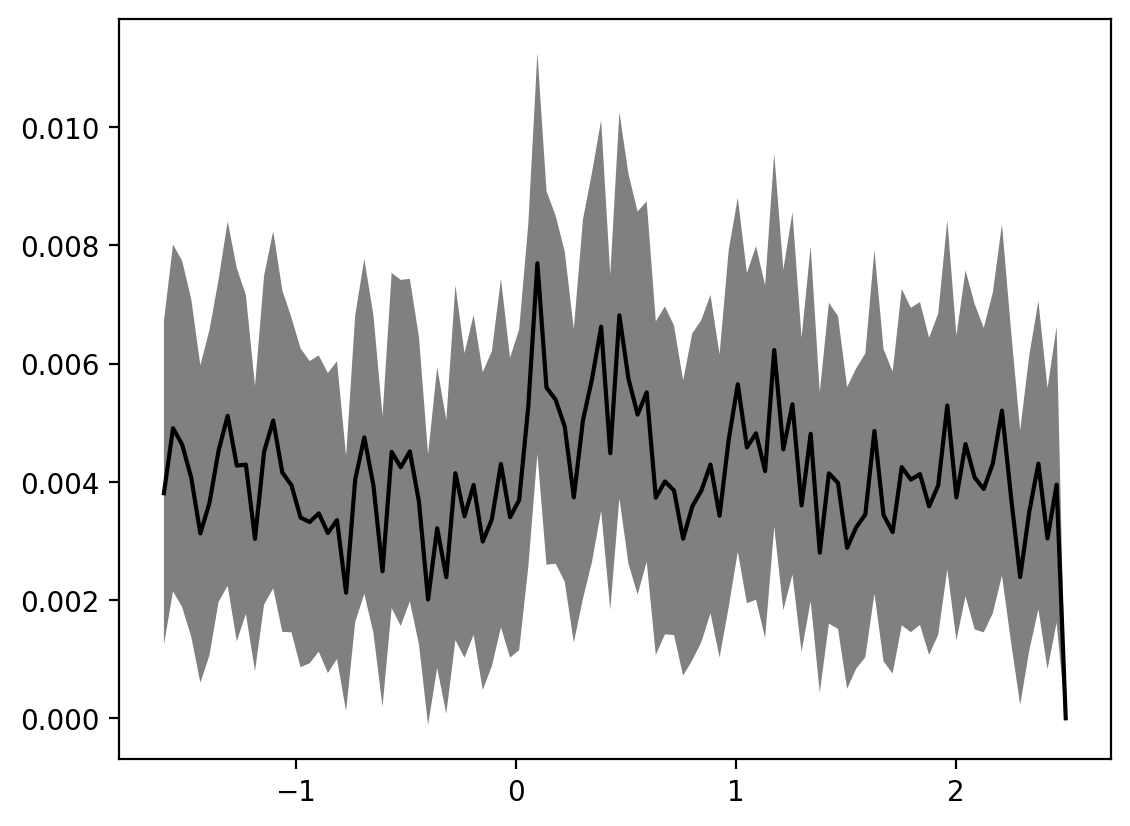

In [5]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl
from datetime import date

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())

## Nos aseguramos de borrar residuos.
try: 
    del IA
    del ampA, PsA, BinEdgesA, maskA
except:
    pass

MaskCR3=(IT["Caracteristicas"][:, 0]>2)*(IT["Caracteristicas"][:, 1]==0)  # CR 3 3b
maskT=(IT["Caracteristicas"][MaskCR3, 2]==0) + (IT["Caracteristicas"][MaskCR3, 2]>3)
amplitudes=IT["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr3 área S1->1")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR3_1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR3_bootstrap_1=np.zeros((nperm, len(I_TCR3_1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR3_bootstrap_1[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr3 área S1->1")
nperm=10000 #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR3_Perm_1=np.zeros((nperm, len(I_TCR3_1)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR3_Perm_1[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR3_bootstrap_1-np.mean(I_T_CR3_Perm_1, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR3_bootstrap_1-np.mean(I_T_CR3_Perm_1, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR3_bootstrap_1, axis=0)- np.mean(I_T_CR3_Perm_1, axis=0), color="k")

# Guardado del resultado
metadata={"area":"1", "RF":3, "mono":(32, 33), "modalidad":"Tactile", "fecha":str(date.today())}
Datos={"Bootstrap":I_T_CR3_bootstrap_1, "Permutaciones": I_T_CR3_Perm_1, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR3Tactil_BootPerm_1.npy", Datos)
print("PotenciaInfCR3Tactile_BootPerm_1.npy \t archivo creado")

keys IT:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Cálculo de bootstrap, para el cr3 área S1->3b
Se realizarán 10000 submuestreos por bootstrap 986049
Cálculo de permutaciones, para el cr3 área S1->3b
Se realizarán 10000 permutaciones 10000
PotenciaInfCR3Tactile_BootPerm_3b.npy 	 archivo creado


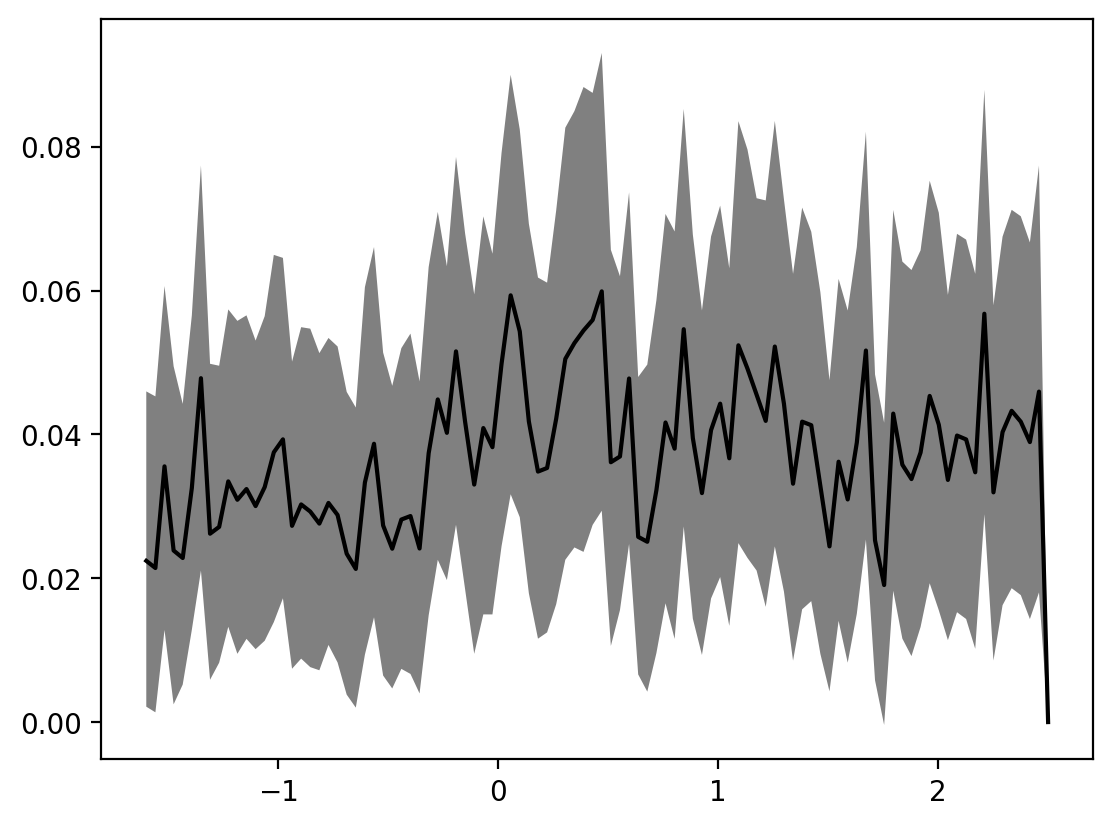

In [10]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import loaddata, optimumC, neuromParams, sigmoidal, calculate_probstim, histograms, Minf, Inf_time
import pickle as pkl
from datetime import date

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
print("keys IT: ", IT.keys())

## Nos aseguramos de borrar residuos.
try: 
    del IA
    del ampA, PsA, BinEdgesA, maskA
except:
    pass

MaskCR3=(IT["Caracteristicas"][:, 0]>2)*(IT["Caracteristicas"][:, 1]==1)  # CR 3 3b
maskT=(IT["Caracteristicas"][MaskCR3, 2]==0) + (IT["Caracteristicas"][MaskCR3, 2]>3)
amplitudes=IT["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskT]
periodicidad=np.vstack(IT["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskT, :]
t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))

print("Cálculo de bootstrap, para el cr3 área S1->3b")
nperm=np.int32(len(periodicidad)*np.log(len(periodicidad)))    # Número de permutaciones
if nperm<10000:
    nperm=10000
print("Se realizarán %d submuestreos por bootstrap"%(nperm), len(periodicidad)**2)  
ampT, PsT=calculate_probstim(amplitudes)  
   
BinEdgesT=np.histogram_bin_edges(periodicidad, bins='doane')
I_TCR3_1=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, nbins=len(BinEdgesT))

I_T_CR3_bootstrap_1=np.zeros((nperm, len(I_TCR3_1)), dtype=np.float32)
indices=np.arange(len(periodicidad))
for boot_i in range(nperm):
    indices_i=np.random.choice(indices, size=len(indices))
    ampT_i, PsT_i=calculate_probstim(amplitudes[indices_i])  
    I_T_CR3_bootstrap_1[boot_i, :]=Inf_time(periodicidad[indices_i, :], np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes[indices_i], ampT_i, PsT_i, len(BinEdgesT))

## Ahora el cálculo de la posible sobreestimación de la información mutua

print("Cálculo de permutaciones, para el cr3 área S1->3b")
nperm=10000 #np.int32(len(periodicidad)*np.log(len(periodicidad)))        # Número de permutaciones
print("Se realizarán %d permutaciones"%(nperm), 10000 )

I_T_CR3_Perm_1=np.zeros((nperm, len(I_TCR3_1)), dtype=np.float32)
for perm_i in range(nperm):
    np.random.shuffle(amplitudes)
    I_T_CR3_Perm_1[perm_i, :]=Inf_time(periodicidad, np.size(periodicidad, axis=1), 
             BinEdgesT, amplitudes, ampT, PsT, len(BinEdgesT))
  
    
## Graficación 
inf=np.quantile(I_T_CR3_bootstrap_1-np.mean(I_T_CR3_Perm_1, axis=0), q=0.025, axis=0)
sup=np.quantile(I_T_CR3_bootstrap_1-np.mean(I_T_CR3_Perm_1, axis=0), q=0.975, axis=0)

plt.figure()

plt.fill_between(t_ext, inf, sup, facecolor="gray")
plt.plot(t_ext, np.mean(I_T_CR3_bootstrap_1, axis=0)- np.mean(I_T_CR3_Perm_1, axis=0), color="k")

# Guardado del resultado
metadata={"area":"3b", "RF":3, "mono":(32, 33), "modalidad":"Tactile", "fecha":str(date.today())}
Datos={"Bootstrap":I_T_CR3_bootstrap_1, "Permutaciones": I_T_CR3_Perm_1, "t":t_ext, "metadata":metadata}
np.save("PotenciaInfCR3Tactil_BootPerm_3b.npy", Datos)
print("PotenciaInfCR3Tactile_BootPerm_3b.npy \t archivo creado")

In [4]:
from datetime import date
print(str(date.today()))

2021-10-20


## Generación de figuras

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib as mpl
import matplotlib.style as ms
mpl.rcParams.update({'font.size': 8, 'font.weight':'bold', 'font.style':'normal'})
#font = "sans-serif"#'tex gyre heros'  # an open type font
#mpl.rcParams['font.sans-serif'] = font
plt.rc('font', family='serif')
mpl.rc('font', size=8)  # change font size from default 10
ms.use('default')
plotparams=({"c":"blue", "label":"Tactile modality"},
            {"c":"crimson","label":"Acoustic modality"}            
           )
CR1T_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalTactilCR1_area1.npz" )
CR1A_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAcusticaCR1_area1.npz")
CR1_3b=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR1_area3b.npz")
CR2_3b=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR2_area3b.npz")
CR2_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR2_areaA1.npz")
CR3_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR3_areaA1.npz")
CR3_3b=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR3_area3b.npz")
per_CR3_3b=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR3_area3b_permutaciones.npz")
per_CR3_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR3_areaA1_permutaciones.npz")
per_CR2_3b=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR2_3b_permutaciones.npz")
per_CR2_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR2_area1_permutaciones.npz")
per_CR1_3b=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR1_3b_permutaciones.npz")
per_CR1_A1=np.load("/home/sparra/MEGA/Prpy/Figuras/InformacionPoblacionalAmbosCR1_A1_permutaciones.npz")

CR1_A1={"I_a_boot":CR1A_A1["I_a_boot"], "I_ac":CR1A_A1["I_ac"], "I_t_boot":CR1T_A1["I_t_boot"], "I_tac":CR1T_A1["I_tac"] }
## Una vez cargados los archivos, empezamos a generar la figura de información.
cm=1/2.54
fig, ax=plt.subplots(3, 2, figsize=(11*cm, 12*cm), sharex=True, sharey=True)
t=np.arange(-0.8, 2.1710, 0.010)
tmp=np.mean(CR1_3b["I_t_boot"], axis=0)[:285]-np.mean(per_CR1_3b["I_t_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[0, 0].plot(t[:285],tmp, **plotparams[0])
ax[0, 0].fill_between(t[:285],tmp -3*np.std(CR1_3b["I_t_boot"], axis=0)[:285], tmp +3*np.std(CR1_3b["I_t_boot"], axis=0)[:285], color="cyan")
tmp= np.mean(CR1_3b["I_a_boot"], axis=0)[:285]-np.mean(per_CR1_3b["I_a_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[0, 0].plot(t[:285],tmp, **plotparams[1])
ax[0, 0].fill_between(t[:285],tmp -3*np.std(CR1_3b["I_a_boot"], axis=0)[:285],tmp + 3*np.std(CR1_3b["I_a_boot"], axis=0)[:285], color="orangered")
tmp=np.mean(CR1_A1["I_t_boot"], axis=0)[:285]-np.mean(per_CR1_A1["I_t_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[0, 1].plot(t[:285],tmp, **plotparams[0])
ax[0, 1].fill_between(t[:285],tmp-3*np.std(CR1_A1["I_t_boot"], axis=0)[:285], tmp+3*np.std(CR1_A1["I_t_boot"], axis=0)[:285],color="cyan")
tmp=np.mean(CR1_A1["I_a_boot"], axis=0)[:285]-np.mean(per_CR1_A1["I_a_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[0, 1].plot(t[:285],tmp, **plotparams[1])
ax[0, 1].fill_between(t[:285],tmp-3*np.std(CR1_A1["I_a_boot"], axis=0)[:285], tmp+3*np.std(CR1_A1["I_a_boot"], axis=0)[:285], color="orangered")
#
tmp=np.mean(CR2_3b["I_t_boot"], axis=0)[:285]-np.mean(per_CR2_3b["I_t_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[1, 0].plot(t[:285],tmp , **plotparams[0])
ax[1, 0].fill_between(t[:285],tmp-3*np.std(CR2_3b["I_t_boot"], axis=0)[:285], tmp+3*np.std(CR2_3b["I_t_boot"], axis=0)[:285], color="cyan")
tmp=np.mean(CR2_3b["I_a_boot"], axis=0)[:285]-np.mean(per_CR2_3b["I_a_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[1, 0].plot(t[:285], tmp, **plotparams[1])
ax[1, 0].fill_between(t[:285], tmp-3*np.std(CR2_3b["I_a_boot"], axis=0)[:285], tmp+3*np.std(CR2_3b["I_a_boot"], axis=0)[:285], color="orangered")
tmp=np.mean(CR2_A1["I_t_boot"], axis=0)[:285]-np.mean(per_CR2_A1["I_t_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[1, 1].plot(t[:285], tmp, **plotparams[0])
ax[1, 1].fill_between(t[:285], tmp-3*np.std(CR2_A1["I_t_boot"], axis=0)[:285], tmp+3*np.std(CR2_A1["I_t_boot"], axis=0)[:285], color="cyan")
tmp=np.mean(CR2_A1["I_a_boot"], axis=0)[:285]-np.mean(per_CR2_A1["I_a_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[1, 1].plot(t[:285],tmp,  **plotparams[1])
ax[1, 1].fill_between(t[:285], tmp-3*np.std(CR2_A1["I_a_boot"], axis=0)[:285], tmp+3*np.std(CR2_A1["I_a_boot"], axis=0)[:285], color="orangered")
#
tmp=np.mean(CR3_3b["I_t_boot"], axis=0)[:285]-np.mean(per_CR3_3b["I_t_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[2, 0].plot(t[:285], tmp, **plotparams[0])
ax[2, 0].fill_between(t[:285], tmp-3*np.std(CR3_3b["I_t_boot"], axis=0)[:285], tmp+3*np.std(CR3_3b["I_t_boot"], axis=0)[:285], color="cyan")
tmp=np.mean(CR3_3b["I_a_boot"], axis=0)[:285]-np.mean(per_CR3_3b["I_a_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[2, 0].plot(t[:285], tmp, **plotparams[1])
ax[2, 0].fill_between(t[:285], tmp-3*np.std(CR3_3b["I_a_boot"], axis=0)[:285], tmp+3*np.std(CR3_3b["I_a_boot"], axis=0)[:285], color="orangered")
tmp=np.mean(CR3_A1["I_t_boot"], axis=0)[:285]-np.mean(per_CR3_A1["I_t_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[2, 1].plot(t[:285], tmp, **plotparams[0])
ax[2, 1].fill_between(t[:285], tmp-3*np.std(CR3_A1["I_t_boot"], axis=0)[:285:], tmp+3*np.std(CR3_A1["I_t_boot"], axis=0)[:285:], color="cyan")
tmp=np.mean(CR3_A1["I_a_boot"], axis=0)[:285]-np.mean(per_CR3_A1["I_a_perm"], axis=0)[1::]
tmp[tmp<0]=0
ax[2, 1].plot(t[:285], tmp, **plotparams[1])
ax[2, 1].fill_between(t[:285], tmp-3*np.std(CR3_A1["I_a_boot"], axis=0)[:285], tmp+3*np.std(CR3_A1["I_a_boot"], axis=0)[:285], color="orangered")


ax[0 ,0].set_xlim([-0.8, 1.7])
ax[0 ,0].set_ylim([-0.02, 0.5])

for ax_i in ax.flatten():
    ax_i.xaxis.set_tick_params(top=False, direction='out', width=2)
    ax_i.yaxis.set_tick_params(right=False, direction='out', width=2)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['top'].set_visible(False)
    ax_i.axvspan(xmin=0, xmax=0.5, facecolor="gray", alpha=0.4)
ax[2, 0].set_xlabel("Time [s]", fontsize=8)
ax[2, 1].set_xlabel("Time [s]", fontsize=8)
ax[0,1].legend(loc="best", frameon=False, fontsize=8)


plt.tight_layout()
#fig.savefig("PobInfor_Bootstrap.svg", format="svg")

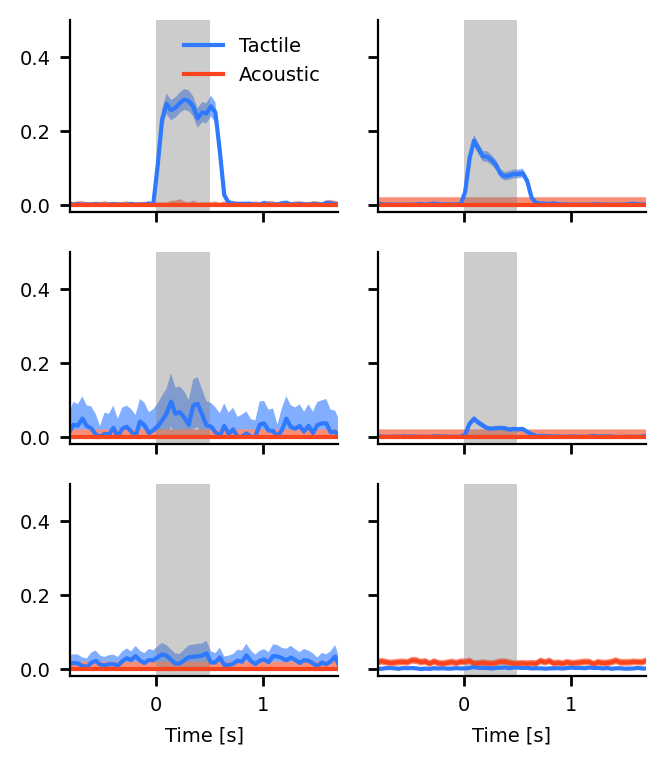

In [2]:
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib as mpl
import matplotlib.style as ms
mpl.rcParams.update({'font.size': 7, 'font.weight':'bold', 'font.style':'normal'})
figsize=(8.7/2.54, 10/2.54)
def bias(modalidad, rf, area=1, bins="doane"):
    if modalidad=="tactile":
        file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
        I=pkl.load(file1)
    else:
        file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
        I=pkl.load(file1)
    file1.close()
    if rf<3:
        maskrf=(I["Caracteristicas"][:, 0]==rf)
    else:
        maskrf=(I["Caracteristicas"][:, 0]>=2)
        
    MaskCR3=maskrf*(I["Caracteristicas"][:, 1]==area)  
    if modalidad=="tactile":
        maskT=(I["Caracteristicas"][MaskCR3, 2]>3) + (I["Caracteristicas"][MaskCR3, 2]==0)
        amplitudes=I["Caracteristicas"][MaskCR3, 2]
        amplitudes=amplitudes[maskT]
        amp=np.unique(amplitudes)
    else:
        maskT=(I["Caracteristicas"][MaskCR3, 2]<3) 
        amplitudes=I["Caracteristicas"][MaskCR3, 2]
        amplitudes=amplitudes[maskT]
        amp=np.unique(amplitudes)
    periodicidad=np.vstack(I["Periodicidad"])[MaskCR3, :]
    periodicidad=periodicidad[maskT, :]
    BinEdgesA=np.histogram_bin_edges(periodicidad, bins=bins)
    bias=Bias_PT(periodicidad, BinEdgesA, amplitudes, amp)
    return bias

#font = "sans-serif"#'tex gyre heros'  # an open type font
#mpl.rcParams['font.sans-serif'] = font
plt.rc('font', family='serif')
mpl.rc('font', size=7)  # change font size from default 10
mpl.rcParams['xtick.labelsize'] = 7

ms.use('default')
plotparams=({"c":(47/255, 121/255, 1.0, 1.0), "label":"Tactile"},
            {"c":(249/255, 68/255, 29/255, 1.0),"label":"Acoustic"},
            {"facecolor":(130/255, 174/255, 1.0, 1.0)},
            {"facecolor":(251/255, 142/255, 119/255, 1.0)},
           )
#PotenciaInfCR3Tactil_BootPerm_1
TCR3_1=np.load("PotenciaInfCR3Tactile_BootPerm_1.npy", allow_pickle=True)
TCR3_3b=np.load("PotenciaInfCR3Tactile_BootPerm_3b.npy", allow_pickle=True)
TCR2_1=np.load("PotenciaInfCR2Tactile_BootPerm_1.npy", allow_pickle=True)
TCR2_3b=np.load("PotenciaInfCR2Tactile_BootPerm_3b.npy", allow_pickle=True)
TCR1_1=np.load("PotenciaInfCR1Tactile_BootPerm_1.npy", allow_pickle=True)
TCR1_3b=np.load("PotenciaInfCR1Tactile_BootPerm_3b.npy", allow_pickle=True)
TCR3_1=TCR3_1.flat[0]
TCR3_3b=TCR3_3b.flat[0]
TCR2_1=TCR2_1.flat[0]
TCR2_3b=TCR2_3b.flat[0]
TCR1_1=TCR1_1.flat[0]
TCR1_3b=TCR1_3b.flat[0]
#
ACR3_1=np.load("PotenciaInfCR3Acoustic_BootPerm_1.npy", allow_pickle=True)
ACR3_3b=np.load("PotenciaInfCR3Acoustic_BootPerm_3b.npy", allow_pickle=True)
ACR2_1=np.load("PotenciaInfCR2Acoustic_BootPerm_1.npy", allow_pickle=True)
ACR2_3b=np.load("PotenciaInfCR2Acoustic_BootPerm_3b.npy", allow_pickle=True)
ACR1_1=np.load("PotenciaInfCR1Acoustic_BootPerm_1.npy", allow_pickle=True)
ACR1_3b=np.load("PotenciaInfCR1Acoustic_BootPerm_3b.npy", allow_pickle=True)
ACR3_1=ACR3_1.flat[0]
positions=np.where(np.isinf(ACR3_1["Bootstrap"]).any(axis=1)==False)[0]
ACR3_1["Bootstrap"]=ACR3_1["Bootstrap"][positions, :]
positions=np.where(np.isinf(ACR3_1["Permutaciones"]).any(axis=1)==False)[0]
ACR3_1["Permutaciones"]=ACR3_1["Permutaciones"][positions, :]
posiciones=np.where(~(ACR3_1["Bootstrap"]>np.log2(6)).any(axis=1))[0]
ACR3_1["Bootstrap"]=ACR3_1["Bootstrap"][posiciones, :]
posiciones=np.where(~(ACR3_1["Permutaciones"]>np.log2(6)).any(axis=1))[0]
ACR3_1["Permutaciones"]=ACR3_1["Permutaciones"][posiciones, :]
#
ACR3_3b=ACR3_3b.flat[0]
ACR2_1=ACR2_1.flat[0]
ACR2_3b=ACR2_3b.flat[0]
ACR1_1=ACR1_1.flat[0]
ACR1_3b=ACR1_3b.flat[0]
#

#
posiciones=np.where(~(TCR2_3b["Bootstrap"]>np.log2(6)).any(axis=1))[0]
TCR2_3b["Bootstrap"]=TCR2_3b["Bootstrap"][posiciones, :]
posiciones=np.where(~(TCR2_3b["Permutaciones"]>np.log2(6)).any(axis=1))[0]
TCR2_3b["Permutaciones"]=TCR2_3b["Permutaciones"][posiciones, :]
#
posiciones=np.where(~(TCR3_3b["Bootstrap"]>np.log2(6)).any(axis=1))[0]
TCR3_3b["Bootstrap"]=TCR3_3b["Bootstrap"][posiciones, :]
posiciones=np.where(~(TCR3_3b["Permutaciones"]>np.log2(6)).any(axis=1))[0]
TCR3_3b["Permutaciones"]=TCR3_3b["Permutaciones"][posiciones, :]
fig, ax=plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)

## GRAFICACIÓN DE LA MODALIDAD TACTIL Y CORRECCIÓN POR EXPANSIÓN ASINTÓTICA


biasc=bias("tactile", 3, area=0, bins="doane")
tmp=np.mean(TCR3_1["Bootstrap"], axis=0)- biasc - np.mean(TCR3_1["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(TCR3_1["Bootstrap"]-np.quantile(TCR3_1["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR3_1["Bootstrap"]-np.quantile(TCR3_1["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[2, 1].fill_between(TCR3_1["t"], inf, sup, **plotparams[2])
ax[2, 1].plot(TCR3_1["t"], tmp, **plotparams[0])
#
biasc=bias("tactile", 2, area=0, bins="doane")
tmp=np.mean(TCR2_1["Bootstrap"], axis=0)- biasc - np.mean(TCR2_1["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(TCR2_1["Bootstrap"]-np.quantile(TCR2_1["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR2_1["Bootstrap"]-np.quantile(TCR2_1["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[1, 1].fill_between(TCR2_1["t"], inf, sup, **plotparams[2])
ax[1, 1].plot(TCR2_1["t"],  tmp, **plotparams[0])
#
biasc=bias("tactile", 1, area=0, bins="doane")
tmp=np.mean(TCR1_1["Bootstrap"], axis=0)- biasc - np.mean(TCR1_1["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(TCR1_1["Bootstrap"]-np.quantile(TCR1_1["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR1_1["Bootstrap"]-np.quantile(TCR1_1["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[0, 1].fill_between(TCR1_1["t"], inf, sup, **plotparams[2])
ax[0, 1].plot(TCR1_1["t"], tmp, **plotparams[0])
#
biasc=bias("tactile", 3, area=1, bins="doane")
tmp=np.mean(TCR3_3b["Bootstrap"], axis=0)- biasc - np.mean(TCR3_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(TCR3_3b["Bootstrap"]-np.quantile(TCR3_3b["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR3_3b["Bootstrap"]-np.quantile(TCR3_3b["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[2, 0].fill_between(TCR3_3b["t"], inf, sup, **plotparams[2])
ax[2, 0].plot(TCR3_3b["t"], tmp, **plotparams[0])
#
biasc=bias("tactile", 2, area=1, bins="doane")
tmp=np.mean(TCR2_3b["Bootstrap"], axis=0)- biasc - np.mean(TCR2_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(TCR2_3b["Bootstrap"]-np.quantile(TCR2_3b["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR2_3b["Bootstrap"]-np.quantile(TCR2_3b["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[1, 0].fill_between(TCR2_3b["t"], inf, sup, **plotparams[2])
ax[1, 0].plot(TCR2_3b["t"], tmp, **plotparams[0])
#
biasc=bias("tactile", 1, area=1, bins="doane")
tmp=np.mean(TCR1_3b["Bootstrap"], axis=0)- biasc - np.mean(TCR1_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(TCR1_3b["Bootstrap"]-np.quantile(TCR1_3b["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR1_3b["Bootstrap"]-np.quantile(TCR1_3b["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[0, 0].fill_between(TCR1_3b["t"], inf, sup, **plotparams[2])
ax[0, 0].plot(TCR1_3b["t"], tmp, **plotparams[0])
## GRAFICACIÓN DE LA MODALIDAD ACÚSTICA
#
biasc=bias("acoustic", 3, area=0, bins="auto")
tmp=np.mean(ACR3_1["Bootstrap"], axis=0)- biasc - np.mean(ACR3_1["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(ACR3_1["Bootstrap"]-np.quantile(ACR3_1["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(ACR3_1["Bootstrap"]-np.quantile(ACR3_1["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[2, 1].fill_between(ACR3_1["t"], inf, sup, **plotparams[3])
ax[2, 1].plot(ACR3_1["t"], tmp, **plotparams[1])
#
biasc=bias("acoustic", 2, area=0, bins="auto")
tmp=np.mean(ACR2_1["Bootstrap"], axis=0)- biasc - np.mean(ACR2_1["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(ACR2_1["Bootstrap"]-np.quantile(ACR2_1["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(ACR2_1["Bootstrap"]-np.quantile(ACR2_1["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[1, 1].fill_between(ACR2_1["t"], inf, sup, **plotparams[3])
ax[1, 1].plot(ACR2_1["t"], tmp, **plotparams[1])
#
biasc=bias("acoustic", 1, area=0, bins="auto")
tmp=np.mean(ACR2_1["Bootstrap"], axis=0)- biasc - np.mean(ACR2_1["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(ACR1_1["Bootstrap"]-np.quantile(ACR1_1["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(ACR1_1["Bootstrap"]-np.quantile(ACR1_1["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[0, 1].fill_between(ACR1_1["t"], inf, sup, **plotparams[3])
ax[0, 1].plot(ACR1_1["t"],tmp, **plotparams[1])
#
biasc=bias("acoustic", 3, area=1, bins="auto")
tmp=np.mean(ACR3_3b["Bootstrap"], axis=0)- biasc - np.mean(ACR3_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(ACR3_3b["Bootstrap"]-np.quantile(ACR3_3b["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(ACR3_3b["Bootstrap"]-np.quantile(ACR3_3b["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[2, 0].fill_between(ACR3_3b["t"], inf, sup, **plotparams[3])
ax[2, 0].plot(ACR3_3b["t"], tmp, **plotparams[1])
#
biasc=bias("acoustic", 2, area=1, bins="auto")
tmp=np.mean(ACR2_3b["Bootstrap"], axis=0)- biasc - np.mean(ACR2_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=np.quantile(ACR2_3b["Bootstrap"]-np.quantile(ACR2_3b["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(ACR2_3b["Bootstrap"]-np.quantile(ACR2_3b["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
ax[1, 0].fill_between(ACR2_3b["t"], inf, sup, **plotparams[3])
ax[1, 0].plot(ACR2_3b["t"], tmp, **plotparams[1])
#
biasc=bias("acoustic", 1, area=1, bins="auto")
tmp=np.mean(ACR1_3b["Bootstrap"], axis=0)- biasc - np.mean(ACR1_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=inf-biasc
inf[inf<0]=0
sup=sup-biasc
sup[sup<0]=0.02
inf=np.quantile(ACR1_3b["Bootstrap"]-np.quantile(ACR1_3b["Permutaciones"], q=0.50, axis=0), q=0.025, axis=0)
sup=np.quantile(ACR1_3b["Bootstrap"]-np.quantile(ACR1_3b["Permutaciones"], q=0.50, axis=0), q=0.975, axis=0)
ax[0, 0].fill_between(ACR1_3b["t"], inf, sup, **plotparams[3])
ax[0, 0].plot(ACR1_3b["t"], tmp, **plotparams[1])

ax[0 ,0].set_xlim([-0.8, 1.7])
ax[0 ,0].set_ylim([-0.02, 0.5])

for ax_i in ax.flatten():
    ax_i.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax_i.yaxis.set_tick_params(right=False, direction='out', width=1)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['top'].set_visible(False)
    ax_i.axvspan(xmin=0, xmax=0.5, facecolor="gray", alpha=0.4)
    ax_i.xaxis.set_tick_params(labelsize=7)
    ax_i.yaxis.set_tick_params(labelsize=7)

ax[2, 0].set_xlabel("Time [s]", fontsize=7)
ax[2, 1].set_xlabel("Time [s]", fontsize=7)
ax[0, 0].legend(loc="best", frameon=False, fontsize=7)


plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#fig.savefig("PobInforPeriodicidad_Bootstrap.svg", format="svg")

### Cálculo del bias para la información mediante la técnica de la expansión asintótica.

$BIAS[I(S;R)]=\frac{1}{2Nln(2)}\left(\sum_{s}{(\bar{R_s}-1)}    -\bar{R}+1 \right)   $

Donde $\bar{R_s}$ representa el número de respuestas R no nulas para el estímulo s.

keys IA:  dict_keys(['p095', 'p099', 'InformacionT', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])


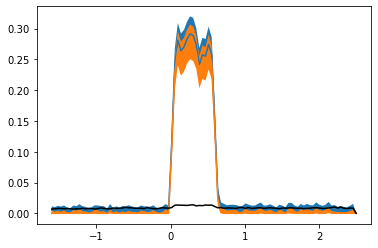

In [6]:
# Cálculo del bias
import numpy as np
import matplotlib.pyplot as plt
from Periodicidad_Info_Neu import histograms, Bias_PT
import pickle as pkl
file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())

MaskCR3=(IA["Caracteristicas"][:, 0]==1)*(IA["Caracteristicas"][:, 1]==1)  # CR 3 area 1
maskA=(IA["Caracteristicas"][MaskCR3, 2]>3) + (IA["Caracteristicas"][MaskCR3, 2]==1)
amplitudes=IA["Caracteristicas"][MaskCR3, 2]
amplitudes=amplitudes[maskA]
amp=np.unique(amplitudes)
periodicidad=np.vstack(IA["Periodicidad"])[MaskCR3, :]
periodicidad=periodicidad[maskA, :]

TCR1_3b=np.load("PotenciaInfCR1Tactile_BootPerm_3b.npy", allow_pickle=True)
TCR1_3b=TCR1_3b.flat[0]

inf=np.quantile(TCR1_3b["Bootstrap"]-np.quantile(TCR1_3b["Permutaciones"], q=0.5, axis=0), q=0.025, axis=0)
sup=np.quantile(TCR1_3b["Bootstrap"]-np.quantile(TCR1_3b["Permutaciones"], q=0.5, axis=0), q=0.975, axis=0)
plt.fill_between(TCR1_3b["t"], inf, sup)
plt.plot(TCR1_3b["t"],  np.mean(TCR1_3b["Bootstrap"], axis=0)- np.quantile(TCR1_3b["Permutaciones"], q=0.5,  axis=0))


t_ext=np.linspace(-1.6, 2.5, np.size(periodicidad, axis=1))
BinEdgesA=np.histogram_bin_edges(periodicidad, bins='doane')
bias=Bias_PT(periodicidad, BinEdgesA, amplitudes, amp)
tmp=np.mean(TCR1_3b["Bootstrap"], axis=0)- bias - np.mean(TCR1_3b["Permutaciones"], axis=0)
tmp[tmp<0]=0
inf=inf-bias
inf[inf<0]=0
sup=sup-bias
sup[sup<0]=0.002
plt.plot(TCR1_3b["t"], tmp )
plt.fill_between(TCR1_3b["t"], inf, sup)
plt.plot(TCR1_3b["t"], bias, c="k")

### Porcentage de neuronas significativas

keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])


NameError: name 'best' is not defined

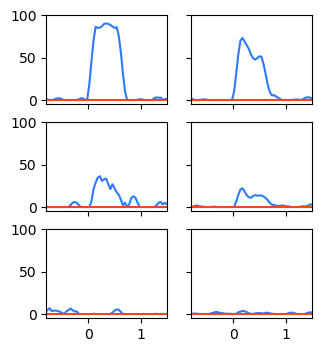

In [31]:
%reset -f
import numpy as np
import pickle as pkl
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as ms
mpl.rcParams.update({'font.size': 8, 'font.weight':'bold', 'font.style':'normal'})
plt.rc('font', family='serif')
mpl.rc('font', size=8)  # change font size from default 10
ms.use('default')
plotparams=({"c":(47/255, 121/255, 1.0, 1.0), "label":"Tactile"},
            {"c":(249/255, 68/255, 29/255, 1.0 ),"label":"Acoustic"}   )
plt.rcParams['svg.fonttype'] = 'none'

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
file1.close()
file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
file1.close()
print("keys IA: ", IA.keys())
pA=np.vstack(IA["p099"])
pT=np.vstack(IT["p099"])
## 
fig, ax=plt.subplots(3, 2, figsize=(8.7/2.54, 10/2.54), sharex=True, sharey=True)
for area in range(2): #0 area 1,  1 area 3b
    maskareaA=(IA["propertiesp"][:, 1]==area)
    maskareaT=(IT["propertiesp"][:, 1]==area)
    if area==0:
        col=1
    else:
        col=0
    for rf in range(1, 4):
        if rf<=2:
            maskrfA=IA["propertiesp"][:, 0]==rf
            maskrfT=IT["propertiesp"][:, 0]==rf
        else:
            maskrfA=IA["propertiesp"][:, 0]>=rf
            maskrfT=IT["propertiesp"][:, 0]>=rf
        maskA=maskrfA*maskareaA
        maskT=maskrfT*maskareaT
        tmp=np.sum(pT[maskT, :], axis=0)/np.sum(maskT)*100
        tmp=savgol_filter(tmp, 7, 3)
        tmp=tmp-np.mean(tmp[0:30])
        tmp[tmp<0]=0
        ax[rf-1, col].plot(IT["t_I"], tmp, **plotparams[0])
        tmp=np.sum(pA[maskA, :], axis=0)/np.sum(maskA)*100
        tmp=savgol_filter(tmp, 7, 3)
        tmp=tmp-np.mean(tmp[0:30])
        tmp[tmp<0]=0
        ax[rf-1, col].plot(IT["t_I"], tmp, **plotparams[1])
ax[0, 0].set_xlim([-0.8, 1.5])
ax[0, 0].set_ylim([-5, 100])
ax[0, 0].legend(loc=best, frameon=False, fontsize=7)
ax[0, 0].set_ylabel("% Neurons", fontsize=7)
ax[2, 0].set_xlabel("Time [s]", fontsize=7)
ax[2, 1].set_xlabel("Time [s]", fontsize=7)
for ax_i in ax.flatten():
    ax_i.xaxis.set_tick_params(top=False, direction='out', width=2)
    ax_i.yaxis.set_tick_params(right=False, direction='out', width=2)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['top'].set_visible(False)
    ax_i.axvspan(0, 0.5, facecolor="gray", alpha=0.25)

plt.tight_layout()
plt.savefig("/home/sparra/MEGA/Prpy/Figuras/PercentageOfNeuronsp001Periodicity.svg", format="svg")

## Distribuciones acumuladas de la información en el periodo de estimulación

keys IA:  dict_keys(['p095', 'p099', 'InformacionA', 'Periodicidad', 'Caracteristicas', 'propertiesp', 't_I'])
Hay 100 elementos en tiempo: 
Analizando area: 0 y campo receptor: 1
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 0 y campo receptor: 1
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 0 y campo receptor: 2
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 0 y campo receptor: 2
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 0 y campo receptor: 3
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 0 y campo receptor: 3
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 1 y campo receptor: 1
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 1 y campo receptor: 1
El tipo de dato tomado es:  <class 'numpy.ndarray'> (322, 100)
Analizando area: 1 y campo receptor: 2
El t

FileNotFoundError: [Errno 2] No such file or directory: '/home/sparra/MEGA/Prpy/CumulativePeriodicity.svg'

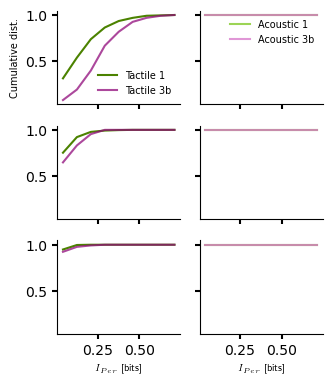

In [1]:
%reset -f
import numpy as np
import pickle as pkl
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as ms
mpl.rcParams.update({'font.size': 8, 'font.weight':'bold', 'font.style':'normal'})
plt.rc('font', family='serif')
mpl.rc('font', size=8)  # change font size from default 10
ms.use('default')
plotparams=(({"c":(75/255, 130/255, 0.0, 1.0), "label":"Tactile 1"},
             {"c":(156/255, 212/255, 85/255, 1.0), "label":"Acoustic 1"} ),
            ({"c":(144/255, 11/255, 123/255, 0.75 ),"label":"Tactile 3b"},
             {"c":(214/255, 116/255, 201/255, 0.75 ),"label":"Acoustic 3b"})
           )
plt.rcParams['svg.fonttype'] = 'none'

file1=open("InformacionPeriodicidadFourierT.pkl", "rb")
IT=pkl.load(file1)
InfoT=np.vstack(IT["InformacionT"])
file1.close()
file1=open("InformacionPeriodicidadFourierA.pkl", "rb")
IA=pkl.load(file1)
InfoA=np.vstack(IA["InformacionA"])
file1.close()
print("keys IA: ", IA.keys())
idx=np.logical_and(IT["t_I"]>=0.1, IT["t_I"]<=0.6 )
print("Hay {} elementos en tiempo: ".format(len(idx)))
bin_edges=np.linspace(0, np.max(IT["InformacionT"][:, idx].flatten()), 10)
x=(bin_edges[0:-1] + bin_edges[1::])/2
## 
fig, ax=plt.subplots(3, 2, figsize=(8.7/2.54, 10/2.54), sharex=True, sharey=True)
for area in range(2): #0 area 1,  1 area 3b
    maskareaA=(IA["propertiesp"][:, 1]==area)
    maskareaT=(IT["propertiesp"][:, 1]==area)
    for rf in range(1, 4):
        if rf<=2:
            maskrfA=IA["propertiesp"][:, 0]==rf
            maskrfT=IT["propertiesp"][:, 0]==rf
        else:
            maskrfA=IA["propertiesp"][:, 0]>=rf
            maskrfT=IT["propertiesp"][:, 0]>=rf
        for modality,Info in enumerate((InfoT, InfoA)):
            if modality==0:
                masktmp=maskrfT*maskareaT
            else:
                masktmp=maskrfA*maskareaA
            print("Analizando area: {} y campo receptor: {}".format(area, rf))
            tmp=Info[masktmp, :]
            print("El tipo de dato tomado es: ", type(tmp), np.shape(InfoT))
            tmp=tmp[:, idx].flatten()
            tmp[tmp<0]=0
            ld=len(tmp)
            tmp, _=np.histogram(tmp, bins=bin_edges)
            tmp=tmp/ld
            tmp=np.cumsum(tmp)
            ax[rf-1, modality].plot(x, tmp, **plotparams[area][modality])

ax[0, 0].legend(loc="best", frameon=False, fontsize=7)
ax[0, 1].legend(loc="best", frameon=False, fontsize=7)
ax[0, 0].set_ylabel("Cumulative dist.", fontsize=7)
ax[-1, 0].set_xlabel("$I_{Per}$ [bits]", fontsize=7, usetex=True)
ax[-1, -1].set_xlabel("$I_{Per}$ [bits]", fontsize=7, usetex=True)


for ax_i in ax.flatten():
    ax_i.xaxis.set_tick_params(top=False, direction='out', width=1.5)
    ax_i.yaxis.set_tick_params(right=False, direction='out', width=1.5)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['top'].set_visible(False)

plt.tight_layout()
# plt.savefig("/home/sparra/MEGA/Prpy/CumulativePeriodicity.svg", format="svg")
# plt.savefig("/home/sparra/MEGA/Prpy/CumulativePeriodicity.pdf", format="pdf")
# plt.savefig("/home/sparra/MEGA/Prpy/CumulativePeriodicity.eps", format="eps")

In [31]:
np.histogram?